In [1]:
import numpy as np 
from numpy import argmax

import tensorflow as tf
import itertools
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.metrics import categorical_crossentropy

from itertools import chain


In [2]:
#Checking for tensorflow-GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [3]:
#Unzipping Attack and Validation folders

# Unzip Attack Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Attack_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Attack File')
    
# Unzip Validation Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Validation_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Validation File')
    
# Unzip Training Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Training_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Training File')

# list holding normal training data
train_normal_data = [] 



from pathlib import Path 
# list that holds attack vectors
train_attack_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Attack_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_attack_data.append(string_split_data)
    

for i in range(len(train_attack_data)):
  for j in range(len(train_attack_data[i])):
    train_attack_data[i][j] = int(train_attack_data[i][j])

from pathlib import Path 
# list that holds validation vectors
train_validation_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Validation_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_validation_data.append(string_split_data)
    

# list that holds training vectors
train_normal_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Training_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_normal_data.append(string_split_data)
    

for i in range(len(train_normal_data)):
  for j in range(len(train_normal_data[i])):
    train_normal_data[i][j] = int(train_normal_data[i][j])
print("Normal Data     --->  train_normal_data")
print("Attack Data     --->  train_attack_data")
print("Validation Data --->  train_validation_data")


Unizipped Attack File
Unizipped Validation File
Unizipped Training File
Normal Data     --->  train_normal_data
Attack Data     --->  train_attack_data
Validation Data --->  train_validation_data


In [4]:
#Statistics of the data

#Shortest request
shortest_seq = 1000;
#Longest request
longest_seq = 0;
#Average Request size in dataset
avg_seq = 0

sum = 0;
for i in range(len(train_normal_data)):
    curr_sequence_length = len(train_normal_data[i])
    if curr_sequence_length < shortest_seq:
        shortest_seq = curr_sequence_length
    if curr_sequence_length > longest_seq:
        longest_seq = curr_sequence_length
    sum += curr_sequence_length
avg_seq = int(sum/len(train_normal_data))

print(f"Shortest Request Length is {shortest_seq}")
print(f"Longest Request Length is {longest_seq}")
print(f"Average Request Length is {avg_seq}")
    

Shortest Request Length is 79
Longest Request Length is 2948
Average Request Length is 369


In [5]:
unique_normal = []
attack_not_in_normal = []
for i in range(len(train_normal_data)):
    for j in range(len(train_normal_data[i])):
        curr_sys_call = train_normal_data[i][j]
        if curr_sys_call in unique_normal:
            continue
        else:
            unique_normal.append(curr_sys_call)

for i in range(len(train_attack_data)):
    for j in range(len(train_attack_data[i])):
        curr_sys_call = train_attack_data[i][j]
        if curr_sys_call not in unique_normal:
            attack_not_in_normal.append(curr_sys_call)

In [6]:
len(unique_normal)

150

In [7]:
attack_not_in_normal

[324, 324, 324, 324, 324, 324, 324, 173, 156]

In [8]:
#Generating one hot vectors
dict = {}
vocab_size = 341

for x in range(vocab_size):
    arr=[]
    arr = [0 for i in range(vocab_size)] 
    arr[x] = 1
    dict[x] = arr

In [9]:
#Sequence size
n = 15
#N-Gram
m = 3

In [10]:
# This method receives a request array and returns one hot encoded version of that array
def generate_trainSet(request):
    temp = []
    for sys_call in request:
        temp.append(dict[sys_call])
    return temp

# This method recevies a request array, start and  end of the request and populates x_train and y_train
# with returned one hot version from the generate_trainSet method
def split_request(source, target, request, start, end):
    while(len(request)-start >= n+m):
        source.append(generate_trainSet(request[start:end]))
        start += m
        end += m
        target.append(generate_trainSet(request[start:end]))
    

In [11]:
x_train = []
y_train = [] 

# Populating x_train and y_train with sources and targets
for i in range(len(train_normal_data)):
    split_request(x_train, y_train, train_normal_data[i],0,n)

In [13]:
print(len(x_train))
print(len(train_normal_data))


98233
833


In [14]:
# Converting x_train and y_train into np arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [15]:
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(98233, 15, 341)


In [16]:
# split test data into training and testing sets
x_train, x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=4)

In [17]:
n_timesteps = n
n_features = vocab_size
numberOfUnits = 200

input= Input(shape=(n_timesteps, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input) 
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = (Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_return_sequences_return_state = Model(input,output,
                                name='model_LSTM_all_state_h_return_state')
model_LSTM_return_sequences_return_state.compile(loss='categorical_crossentropy', 
                                                 optimizer='adam',
                                                 metrics=['accuracy'])
model_LSTM_return_sequences_return_state.summary()

Model: "model_LSTM_all_state_h_return_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 341)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 15, 200),    433600      ['input_1[0][0]']                
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  (None, 15, 200)      320800      ['lstm[0][0]',                   
                                                                

In [18]:
def train_test(model, X_train, y_train , 
               X_test, 	y_test, epochs=50, 
							        verbose=0, patience=5):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', 
	                   verbose=1, patience=patience)
	# train model
	print('training for ',epochs,
	      ' epochs begins with',
				' EarlyStopping(monitor= val_loss ',
				' patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,  verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

training for  50  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
Epoch 19: early stopping
50  epoch training finished...
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

PREDICTION ACCURACY (%):
Train: 95.413, Test: 92.671


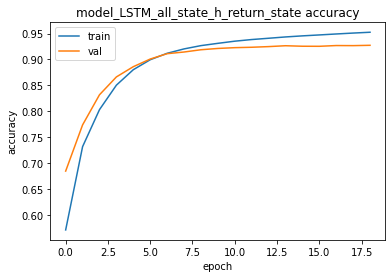

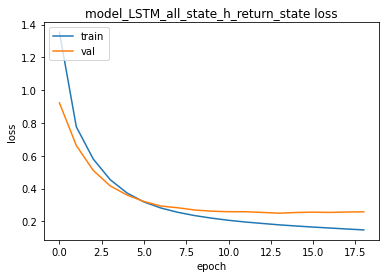

In [19]:
train_test(model_LSTM_return_sequences_return_state, x_train, y_train , x_test, y_test)

In [20]:
# import os.path
# if os.path.isfile('models/LSTM_HIDS.h5') is False:
#     model_LSTM_return_sequences_return_state.save('models/LSTM_HIDS.h5')

In [21]:
def one_hot_decode(arr):
    for index,num in enumerate(arr):
        if num == 1:
            return index

def decode(arr, three_d_array):
    for seq in three_d_array:
        temp = []
        for one_hot in seq:
            temp.append(one_hot_decode(one_hot))
        arr.append(temp)
    
        

In [22]:
def prediction_decode(arr, prediction):
    for seq in prediction:
        predict_temp = []
        for one_hot in seq:
            predict_temp.append(argmax(one_hot))
        arr.append(predict_temp)
    
    

In [23]:
# len(x_test)

In [24]:
# Decoded vectors x_test and y_test
x_test_decoded = []
y_test_decoded = []
i = 1

#For simplicity, test number
test_number = len(x_test)

while(i < test_number):
    decode(x_test_decoded,x_test[i-1:i])
    decode(y_test_decoded,y_test[i-1:i])
    i += 1

In [25]:
predictions = []
i = 1
while(i < test_number):
    prediction_decode(predictions, model_LSTM_return_sequences_return_state.predict(x_test[i-1:i]))
    print(i, "/", test_number)
    i += 1



1 / 19647
2 / 19647
3 / 19647
4 / 19647
5 / 19647
6 / 19647
7 / 19647
8 / 19647
9 / 19647
10 / 19647
11 / 19647
12 / 19647
13 / 19647
14 / 19647
15 / 19647
16 / 19647
17 / 19647
18 / 19647
19 / 19647
20 / 19647
21 / 19647
22 / 19647
23 / 19647
24 / 19647
25 / 19647
26 / 19647
27 / 19647
28 / 19647
29 / 19647
30 / 19647
31 / 19647
32 / 19647
33 / 19647
34 / 19647
35 / 19647
36 / 19647
37 / 19647
38 / 19647
39 / 19647
40 / 19647
41 / 19647
42 / 19647
43 / 19647
44 / 19647
45 / 19647
46 / 19647
47 / 19647
48 / 19647
49 / 19647
50 / 19647
51 / 19647
52 / 19647
53 / 19647
54 / 19647
55 / 19647
56 / 19647
57 / 19647
58 / 19647
59 / 19647
60 / 19647
61 / 19647
62 / 19647
63 / 19647
64 / 19647
65 / 19647
66 / 19647
67 / 19647
68 / 19647
69 / 19647
70 / 19647
71 / 19647
72 / 19647
73 / 19647
74 / 19647
75 / 19647
76 / 19647
77 / 19647
78 / 19647
79 / 19647
80 / 19647
81 / 19647
82 / 19647
83 / 19647
84 / 19647
85 / 19647
86 / 19647
87 / 19647
88 / 19647
89 / 19647
90 / 19647
91 / 19647
92 / 196

697 / 19647
698 / 19647
699 / 19647
700 / 19647
701 / 19647
702 / 19647
703 / 19647
704 / 19647
705 / 19647
706 / 19647
707 / 19647
708 / 19647
709 / 19647
710 / 19647
711 / 19647
712 / 19647
713 / 19647
714 / 19647
715 / 19647
716 / 19647
717 / 19647
718 / 19647
719 / 19647
720 / 19647
721 / 19647
722 / 19647
723 / 19647
724 / 19647
725 / 19647
726 / 19647
727 / 19647
728 / 19647
729 / 19647
730 / 19647
731 / 19647
732 / 19647
733 / 19647
734 / 19647
735 / 19647
736 / 19647
737 / 19647
738 / 19647
739 / 19647
740 / 19647
741 / 19647
742 / 19647
743 / 19647
744 / 19647
745 / 19647
746 / 19647
747 / 19647
748 / 19647
749 / 19647
750 / 19647
751 / 19647
752 / 19647
753 / 19647
754 / 19647
755 / 19647
756 / 19647
757 / 19647
758 / 19647
759 / 19647
760 / 19647
761 / 19647
762 / 19647
763 / 19647
764 / 19647
765 / 19647
766 / 19647
767 / 19647
768 / 19647
769 / 19647
770 / 19647
771 / 19647
772 / 19647
773 / 19647
774 / 19647
775 / 19647
776 / 19647
777 / 19647
778 / 19647
779 / 19647
780 

1352 / 19647
1353 / 19647
1354 / 19647
1355 / 19647
1356 / 19647
1357 / 19647
1358 / 19647
1359 / 19647
1360 / 19647
1361 / 19647
1362 / 19647
1363 / 19647
1364 / 19647
1365 / 19647
1366 / 19647
1367 / 19647
1368 / 19647
1369 / 19647
1370 / 19647
1371 / 19647
1372 / 19647
1373 / 19647
1374 / 19647
1375 / 19647
1376 / 19647
1377 / 19647
1378 / 19647
1379 / 19647
1380 / 19647
1381 / 19647
1382 / 19647
1383 / 19647
1384 / 19647
1385 / 19647
1386 / 19647
1387 / 19647
1388 / 19647
1389 / 19647
1390 / 19647
1391 / 19647
1392 / 19647
1393 / 19647
1394 / 19647
1395 / 19647
1396 / 19647
1397 / 19647
1398 / 19647
1399 / 19647
1400 / 19647
1401 / 19647
1402 / 19647
1403 / 19647
1404 / 19647
1405 / 19647
1406 / 19647
1407 / 19647
1408 / 19647
1409 / 19647
1410 / 19647
1411 / 19647
1412 / 19647
1413 / 19647
1414 / 19647
1415 / 19647
1416 / 19647
1417 / 19647
1418 / 19647
1419 / 19647
1420 / 19647
1421 / 19647
1422 / 19647
1423 / 19647
1424 / 19647
1425 / 19647
1426 / 19647
1427 / 19647
1428 / 19647

1985 / 19647
1986 / 19647
1987 / 19647
1988 / 19647
1989 / 19647
1990 / 19647
1991 / 19647
1992 / 19647
1993 / 19647
1994 / 19647
1995 / 19647
1996 / 19647
1997 / 19647
1998 / 19647
1999 / 19647
2000 / 19647
2001 / 19647
2002 / 19647
2003 / 19647
2004 / 19647
2005 / 19647
2006 / 19647
2007 / 19647
2008 / 19647
2009 / 19647
2010 / 19647
2011 / 19647
2012 / 19647
2013 / 19647
2014 / 19647
2015 / 19647
2016 / 19647
2017 / 19647
2018 / 19647
2019 / 19647
2020 / 19647
2021 / 19647
2022 / 19647
2023 / 19647
2024 / 19647
2025 / 19647
2026 / 19647
2027 / 19647
2028 / 19647
2029 / 19647
2030 / 19647
2031 / 19647
2032 / 19647
2033 / 19647
2034 / 19647
2035 / 19647
2036 / 19647
2037 / 19647
2038 / 19647
2039 / 19647
2040 / 19647
2041 / 19647
2042 / 19647
2043 / 19647
2044 / 19647
2045 / 19647
2046 / 19647
2047 / 19647
2048 / 19647
2049 / 19647
2050 / 19647
2051 / 19647
2052 / 19647
2053 / 19647
2054 / 19647
2055 / 19647
2056 / 19647
2057 / 19647
2058 / 19647
2059 / 19647
2060 / 19647
2061 / 19647

2619 / 19647
2620 / 19647
2621 / 19647
2622 / 19647
2623 / 19647
2624 / 19647
2625 / 19647
2626 / 19647
2627 / 19647
2628 / 19647
2629 / 19647
2630 / 19647
2631 / 19647
2632 / 19647
2633 / 19647
2634 / 19647
2635 / 19647
2636 / 19647
2637 / 19647
2638 / 19647
2639 / 19647
2640 / 19647
2641 / 19647
2642 / 19647
2643 / 19647
2644 / 19647
2645 / 19647
2646 / 19647
2647 / 19647
2648 / 19647
2649 / 19647
2650 / 19647
2651 / 19647
2652 / 19647
2653 / 19647
2654 / 19647
2655 / 19647
2656 / 19647
2657 / 19647
2658 / 19647
2659 / 19647
2660 / 19647
2661 / 19647
2662 / 19647
2663 / 19647
2664 / 19647
2665 / 19647
2666 / 19647
2667 / 19647
2668 / 19647
2669 / 19647
2670 / 19647
2671 / 19647
2672 / 19647
2673 / 19647
2674 / 19647
2675 / 19647
2676 / 19647
2677 / 19647
2678 / 19647
2679 / 19647
2680 / 19647
2681 / 19647
2682 / 19647
2683 / 19647
2684 / 19647
2685 / 19647
2686 / 19647
2687 / 19647
2688 / 19647
2689 / 19647
2690 / 19647
2691 / 19647
2692 / 19647
2693 / 19647
2694 / 19647
2695 / 19647

3254 / 19647
3255 / 19647
3256 / 19647
3257 / 19647
3258 / 19647
3259 / 19647
3260 / 19647
3261 / 19647
3262 / 19647
3263 / 19647
3264 / 19647
3265 / 19647
3266 / 19647
3267 / 19647
3268 / 19647
3269 / 19647
3270 / 19647
3271 / 19647
3272 / 19647
3273 / 19647
3274 / 19647
3275 / 19647
3276 / 19647
3277 / 19647
3278 / 19647
3279 / 19647
3280 / 19647
3281 / 19647
3282 / 19647
3283 / 19647
3284 / 19647
3285 / 19647
3286 / 19647
3287 / 19647
3288 / 19647
3289 / 19647
3290 / 19647
3291 / 19647
3292 / 19647
3293 / 19647
3294 / 19647
3295 / 19647
3296 / 19647
3297 / 19647
3298 / 19647
3299 / 19647
3300 / 19647
3301 / 19647
3302 / 19647
3303 / 19647
3304 / 19647
3305 / 19647
3306 / 19647
3307 / 19647
3308 / 19647
3309 / 19647
3310 / 19647
3311 / 19647
3312 / 19647
3313 / 19647
3314 / 19647
3315 / 19647
3316 / 19647
3317 / 19647
3318 / 19647
3319 / 19647
3320 / 19647
3321 / 19647
3322 / 19647
3323 / 19647
3324 / 19647
3325 / 19647
3326 / 19647
3327 / 19647
3328 / 19647
3329 / 19647
3330 / 19647

3886 / 19647
3887 / 19647
3888 / 19647
3889 / 19647
3890 / 19647
3891 / 19647
3892 / 19647
3893 / 19647
3894 / 19647
3895 / 19647
3896 / 19647
3897 / 19647
3898 / 19647
3899 / 19647
3900 / 19647
3901 / 19647
3902 / 19647
3903 / 19647
3904 / 19647
3905 / 19647
3906 / 19647
3907 / 19647
3908 / 19647
3909 / 19647
3910 / 19647
3911 / 19647
3912 / 19647
3913 / 19647
3914 / 19647
3915 / 19647
3916 / 19647
3917 / 19647
3918 / 19647
3919 / 19647
3920 / 19647
3921 / 19647
3922 / 19647
3923 / 19647
3924 / 19647
3925 / 19647
3926 / 19647
3927 / 19647
3928 / 19647
3929 / 19647
3930 / 19647
3931 / 19647
3932 / 19647
3933 / 19647
3934 / 19647
3935 / 19647
3936 / 19647
3937 / 19647
3938 / 19647
3939 / 19647
3940 / 19647
3941 / 19647
3942 / 19647
3943 / 19647
3944 / 19647
3945 / 19647
3946 / 19647
3947 / 19647
3948 / 19647
3949 / 19647
3950 / 19647
3951 / 19647
3952 / 19647
3953 / 19647
3954 / 19647
3955 / 19647
3956 / 19647
3957 / 19647
3958 / 19647
3959 / 19647
3960 / 19647
3961 / 19647
3962 / 19647

4522 / 19647
4523 / 19647
4524 / 19647
4525 / 19647
4526 / 19647
4527 / 19647
4528 / 19647
4529 / 19647
4530 / 19647
4531 / 19647
4532 / 19647
4533 / 19647
4534 / 19647
4535 / 19647
4536 / 19647
4537 / 19647
4538 / 19647
4539 / 19647
4540 / 19647
4541 / 19647
4542 / 19647
4543 / 19647
4544 / 19647
4545 / 19647
4546 / 19647
4547 / 19647
4548 / 19647
4549 / 19647
4550 / 19647
4551 / 19647
4552 / 19647
4553 / 19647
4554 / 19647
4555 / 19647
4556 / 19647
4557 / 19647
4558 / 19647
4559 / 19647
4560 / 19647
4561 / 19647
4562 / 19647
4563 / 19647
4564 / 19647
4565 / 19647
4566 / 19647
4567 / 19647
4568 / 19647
4569 / 19647
4570 / 19647
4571 / 19647
4572 / 19647
4573 / 19647
4574 / 19647
4575 / 19647
4576 / 19647
4577 / 19647
4578 / 19647
4579 / 19647
4580 / 19647
4581 / 19647
4582 / 19647
4583 / 19647
4584 / 19647
4585 / 19647
4586 / 19647
4587 / 19647
4588 / 19647
4589 / 19647
4590 / 19647
4591 / 19647
4592 / 19647
4593 / 19647
4594 / 19647
4595 / 19647
4596 / 19647
4597 / 19647
4598 / 19647

5153 / 19647
5154 / 19647
5155 / 19647
5156 / 19647
5157 / 19647
5158 / 19647
5159 / 19647
5160 / 19647
5161 / 19647
5162 / 19647
5163 / 19647
5164 / 19647
5165 / 19647
5166 / 19647
5167 / 19647
5168 / 19647
5169 / 19647
5170 / 19647
5171 / 19647
5172 / 19647
5173 / 19647
5174 / 19647
5175 / 19647
5176 / 19647
5177 / 19647
5178 / 19647
5179 / 19647
5180 / 19647
5181 / 19647
5182 / 19647
5183 / 19647
5184 / 19647
5185 / 19647
5186 / 19647
5187 / 19647
5188 / 19647
5189 / 19647
5190 / 19647
5191 / 19647
5192 / 19647
5193 / 19647
5194 / 19647
5195 / 19647
5196 / 19647
5197 / 19647
5198 / 19647
5199 / 19647
5200 / 19647
5201 / 19647
5202 / 19647
5203 / 19647
5204 / 19647
5205 / 19647
5206 / 19647
5207 / 19647
5208 / 19647
5209 / 19647
5210 / 19647
5211 / 19647
5212 / 19647
5213 / 19647
5214 / 19647
5215 / 19647
5216 / 19647
5217 / 19647
5218 / 19647
5219 / 19647
5220 / 19647
5221 / 19647
5222 / 19647
5223 / 19647
5224 / 19647
5225 / 19647
5226 / 19647
5227 / 19647
5228 / 19647
5229 / 19647

5784 / 19647
5785 / 19647
5786 / 19647
5787 / 19647
5788 / 19647
5789 / 19647
5790 / 19647
5791 / 19647
5792 / 19647
5793 / 19647
5794 / 19647
5795 / 19647
5796 / 19647
5797 / 19647
5798 / 19647
5799 / 19647
5800 / 19647
5801 / 19647
5802 / 19647
5803 / 19647
5804 / 19647
5805 / 19647
5806 / 19647
5807 / 19647
5808 / 19647
5809 / 19647
5810 / 19647
5811 / 19647
5812 / 19647
5813 / 19647
5814 / 19647
5815 / 19647
5816 / 19647
5817 / 19647
5818 / 19647
5819 / 19647
5820 / 19647
5821 / 19647
5822 / 19647
5823 / 19647
5824 / 19647
5825 / 19647
5826 / 19647
5827 / 19647
5828 / 19647
5829 / 19647
5830 / 19647
5831 / 19647
5832 / 19647
5833 / 19647
5834 / 19647
5835 / 19647
5836 / 19647
5837 / 19647
5838 / 19647
5839 / 19647
5840 / 19647
5841 / 19647
5842 / 19647
5843 / 19647
5844 / 19647
5845 / 19647
5846 / 19647
5847 / 19647
5848 / 19647
5849 / 19647
5850 / 19647
5851 / 19647
5852 / 19647
5853 / 19647
5854 / 19647
5855 / 19647
5856 / 19647
5857 / 19647
5858 / 19647
5859 / 19647
5860 / 19647

6419 / 19647
6420 / 19647
6421 / 19647
6422 / 19647
6423 / 19647
6424 / 19647
6425 / 19647
6426 / 19647
6427 / 19647
6428 / 19647
6429 / 19647
6430 / 19647
6431 / 19647
6432 / 19647
6433 / 19647
6434 / 19647
6435 / 19647
6436 / 19647
6437 / 19647
6438 / 19647
6439 / 19647
6440 / 19647
6441 / 19647
6442 / 19647
6443 / 19647
6444 / 19647
6445 / 19647
6446 / 19647
6447 / 19647
6448 / 19647
6449 / 19647
6450 / 19647
6451 / 19647
6452 / 19647
6453 / 19647
6454 / 19647
6455 / 19647
6456 / 19647
6457 / 19647
6458 / 19647
6459 / 19647
6460 / 19647
6461 / 19647
6462 / 19647
6463 / 19647
6464 / 19647
6465 / 19647
6466 / 19647
6467 / 19647
6468 / 19647
6469 / 19647
6470 / 19647
6471 / 19647
6472 / 19647
6473 / 19647
6474 / 19647
6475 / 19647
6476 / 19647
6477 / 19647
6478 / 19647
6479 / 19647
6480 / 19647
6481 / 19647
6482 / 19647
6483 / 19647
6484 / 19647
6485 / 19647
6486 / 19647
6487 / 19647
6488 / 19647
6489 / 19647
6490 / 19647
6491 / 19647
6492 / 19647
6493 / 19647
6494 / 19647
6495 / 19647

7052 / 19647
7053 / 19647
7054 / 19647
7055 / 19647
7056 / 19647
7057 / 19647
7058 / 19647
7059 / 19647
7060 / 19647
7061 / 19647
7062 / 19647
7063 / 19647
7064 / 19647
7065 / 19647
7066 / 19647
7067 / 19647
7068 / 19647
7069 / 19647
7070 / 19647
7071 / 19647
7072 / 19647
7073 / 19647
7074 / 19647
7075 / 19647
7076 / 19647
7077 / 19647
7078 / 19647
7079 / 19647
7080 / 19647
7081 / 19647
7082 / 19647
7083 / 19647
7084 / 19647
7085 / 19647
7086 / 19647
7087 / 19647
7088 / 19647
7089 / 19647
7090 / 19647
7091 / 19647
7092 / 19647
7093 / 19647
7094 / 19647
7095 / 19647
7096 / 19647
7097 / 19647
7098 / 19647
7099 / 19647
7100 / 19647
7101 / 19647
7102 / 19647
7103 / 19647
7104 / 19647
7105 / 19647
7106 / 19647
7107 / 19647
7108 / 19647
7109 / 19647
7110 / 19647
7111 / 19647
7112 / 19647
7113 / 19647
7114 / 19647
7115 / 19647
7116 / 19647
7117 / 19647
7118 / 19647
7119 / 19647
7120 / 19647
7121 / 19647
7122 / 19647
7123 / 19647
7124 / 19647
7125 / 19647
7126 / 19647
7127 / 19647
7128 / 19647

7683 / 19647
7684 / 19647
7685 / 19647
7686 / 19647
7687 / 19647
7688 / 19647
7689 / 19647
7690 / 19647
7691 / 19647
7692 / 19647
7693 / 19647
7694 / 19647
7695 / 19647
7696 / 19647
7697 / 19647
7698 / 19647
7699 / 19647
7700 / 19647
7701 / 19647
7702 / 19647
7703 / 19647
7704 / 19647
7705 / 19647
7706 / 19647
7707 / 19647
7708 / 19647
7709 / 19647
7710 / 19647
7711 / 19647
7712 / 19647
7713 / 19647
7714 / 19647
7715 / 19647
7716 / 19647
7717 / 19647
7718 / 19647
7719 / 19647
7720 / 19647
7721 / 19647
7722 / 19647
7723 / 19647
7724 / 19647
7725 / 19647
7726 / 19647
7727 / 19647
7728 / 19647
7729 / 19647
7730 / 19647
7731 / 19647
7732 / 19647
7733 / 19647
7734 / 19647
7735 / 19647
7736 / 19647
7737 / 19647
7738 / 19647
7739 / 19647
7740 / 19647
7741 / 19647
7742 / 19647
7743 / 19647
7744 / 19647
7745 / 19647
7746 / 19647
7747 / 19647
7748 / 19647
7749 / 19647
7750 / 19647
7751 / 19647
7752 / 19647
7753 / 19647
7754 / 19647
7755 / 19647
7756 / 19647
7757 / 19647
7758 / 19647
7759 / 19647

8315 / 19647
8316 / 19647
8317 / 19647
8318 / 19647
8319 / 19647
8320 / 19647
8321 / 19647
8322 / 19647
8323 / 19647
8324 / 19647
8325 / 19647
8326 / 19647
8327 / 19647
8328 / 19647
8329 / 19647
8330 / 19647
8331 / 19647
8332 / 19647
8333 / 19647
8334 / 19647
8335 / 19647
8336 / 19647
8337 / 19647
8338 / 19647
8339 / 19647
8340 / 19647
8341 / 19647
8342 / 19647
8343 / 19647
8344 / 19647
8345 / 19647
8346 / 19647
8347 / 19647
8348 / 19647
8349 / 19647
8350 / 19647
8351 / 19647
8352 / 19647
8353 / 19647
8354 / 19647
8355 / 19647
8356 / 19647
8357 / 19647
8358 / 19647
8359 / 19647
8360 / 19647
8361 / 19647
8362 / 19647
8363 / 19647
8364 / 19647
8365 / 19647
8366 / 19647
8367 / 19647
8368 / 19647
8369 / 19647
8370 / 19647
8371 / 19647
8372 / 19647
8373 / 19647
8374 / 19647
8375 / 19647
8376 / 19647
8377 / 19647
8378 / 19647
8379 / 19647
8380 / 19647
8381 / 19647
8382 / 19647
8383 / 19647
8384 / 19647
8385 / 19647
8386 / 19647
8387 / 19647
8388 / 19647
8389 / 19647
8390 / 19647
8391 / 19647

8947 / 19647
8948 / 19647
8949 / 19647
8950 / 19647
8951 / 19647
8952 / 19647
8953 / 19647
8954 / 19647
8955 / 19647
8956 / 19647
8957 / 19647
8958 / 19647
8959 / 19647
8960 / 19647
8961 / 19647
8962 / 19647
8963 / 19647
8964 / 19647
8965 / 19647
8966 / 19647
8967 / 19647
8968 / 19647
8969 / 19647
8970 / 19647
8971 / 19647
8972 / 19647
8973 / 19647
8974 / 19647
8975 / 19647
8976 / 19647
8977 / 19647
8978 / 19647
8979 / 19647
8980 / 19647
8981 / 19647
8982 / 19647
8983 / 19647
8984 / 19647
8985 / 19647
8986 / 19647
8987 / 19647
8988 / 19647
8989 / 19647
8990 / 19647
8991 / 19647
8992 / 19647
8993 / 19647
8994 / 19647
8995 / 19647
8996 / 19647
8997 / 19647
8998 / 19647
8999 / 19647
9000 / 19647
9001 / 19647
9002 / 19647
9003 / 19647
9004 / 19647
9005 / 19647
9006 / 19647
9007 / 19647
9008 / 19647
9009 / 19647
9010 / 19647
9011 / 19647
9012 / 19647
9013 / 19647
9014 / 19647
9015 / 19647
9016 / 19647
9017 / 19647
9018 / 19647
9019 / 19647
9020 / 19647
9021 / 19647
9022 / 19647
9023 / 19647

9580 / 19647
9581 / 19647
9582 / 19647
9583 / 19647
9584 / 19647
9585 / 19647
9586 / 19647
9587 / 19647
9588 / 19647
9589 / 19647
9590 / 19647
9591 / 19647
9592 / 19647
9593 / 19647
9594 / 19647
9595 / 19647
9596 / 19647
9597 / 19647
9598 / 19647
9599 / 19647
9600 / 19647
9601 / 19647
9602 / 19647
9603 / 19647
9604 / 19647
9605 / 19647
9606 / 19647
9607 / 19647
9608 / 19647
9609 / 19647
9610 / 19647
9611 / 19647
9612 / 19647
9613 / 19647
9614 / 19647
9615 / 19647
9616 / 19647
9617 / 19647
9618 / 19647
9619 / 19647
9620 / 19647
9621 / 19647
9622 / 19647
9623 / 19647
9624 / 19647
9625 / 19647
9626 / 19647
9627 / 19647
9628 / 19647
9629 / 19647
9630 / 19647
9631 / 19647
9632 / 19647
9633 / 19647
9634 / 19647
9635 / 19647
9636 / 19647
9637 / 19647
9638 / 19647
9639 / 19647
9640 / 19647
9641 / 19647
9642 / 19647
9643 / 19647
9644 / 19647
9645 / 19647
9646 / 19647
9647 / 19647
9648 / 19647
9649 / 19647
9650 / 19647
9651 / 19647
9652 / 19647
9653 / 19647
9654 / 19647
9655 / 19647
9656 / 19647

10198 / 19647
10199 / 19647
10200 / 19647
10201 / 19647
10202 / 19647
10203 / 19647
10204 / 19647
10205 / 19647
10206 / 19647
10207 / 19647
10208 / 19647
10209 / 19647
10210 / 19647
10211 / 19647
10212 / 19647
10213 / 19647
10214 / 19647
10215 / 19647
10216 / 19647
10217 / 19647
10218 / 19647
10219 / 19647
10220 / 19647
10221 / 19647
10222 / 19647
10223 / 19647
10224 / 19647
10225 / 19647
10226 / 19647
10227 / 19647
10228 / 19647
10229 / 19647
10230 / 19647
10231 / 19647
10232 / 19647
10233 / 19647
10234 / 19647
10235 / 19647
10236 / 19647
10237 / 19647
10238 / 19647
10239 / 19647
10240 / 19647
10241 / 19647
10242 / 19647
10243 / 19647
10244 / 19647
10245 / 19647
10246 / 19647
10247 / 19647
10248 / 19647
10249 / 19647
10250 / 19647
10251 / 19647
10252 / 19647
10253 / 19647
10254 / 19647
10255 / 19647
10256 / 19647
10257 / 19647
10258 / 19647
10259 / 19647
10260 / 19647
10261 / 19647
10262 / 19647
10263 / 19647
10264 / 19647
10265 / 19647
10266 / 19647
10267 / 19647
10268 / 19647
10269 

10788 / 19647
10789 / 19647
10790 / 19647
10791 / 19647
10792 / 19647
10793 / 19647
10794 / 19647
10795 / 19647
10796 / 19647
10797 / 19647
10798 / 19647
10799 / 19647
10800 / 19647
10801 / 19647
10802 / 19647
10803 / 19647
10804 / 19647
10805 / 19647
10806 / 19647
10807 / 19647
10808 / 19647
10809 / 19647
10810 / 19647
10811 / 19647
10812 / 19647
10813 / 19647
10814 / 19647
10815 / 19647
10816 / 19647
10817 / 19647
10818 / 19647
10819 / 19647
10820 / 19647
10821 / 19647
10822 / 19647
10823 / 19647
10824 / 19647
10825 / 19647
10826 / 19647
10827 / 19647
10828 / 19647
10829 / 19647
10830 / 19647
10831 / 19647
10832 / 19647
10833 / 19647
10834 / 19647
10835 / 19647
10836 / 19647
10837 / 19647
10838 / 19647
10839 / 19647
10840 / 19647
10841 / 19647
10842 / 19647
10843 / 19647
10844 / 19647
10845 / 19647
10846 / 19647
10847 / 19647
10848 / 19647
10849 / 19647
10850 / 19647
10851 / 19647
10852 / 19647
10853 / 19647
10854 / 19647
10855 / 19647
10856 / 19647
10857 / 19647
10858 / 19647
10859 

11374 / 19647
11375 / 19647
11376 / 19647
11377 / 19647
11378 / 19647
11379 / 19647
11380 / 19647
11381 / 19647
11382 / 19647
11383 / 19647
11384 / 19647
11385 / 19647
11386 / 19647
11387 / 19647
11388 / 19647
11389 / 19647
11390 / 19647
11391 / 19647
11392 / 19647
11393 / 19647
11394 / 19647
11395 / 19647
11396 / 19647
11397 / 19647
11398 / 19647
11399 / 19647
11400 / 19647
11401 / 19647
11402 / 19647
11403 / 19647
11404 / 19647
11405 / 19647
11406 / 19647
11407 / 19647
11408 / 19647
11409 / 19647
11410 / 19647
11411 / 19647
11412 / 19647
11413 / 19647
11414 / 19647
11415 / 19647
11416 / 19647
11417 / 19647
11418 / 19647
11419 / 19647
11420 / 19647
11421 / 19647
11422 / 19647
11423 / 19647
11424 / 19647
11425 / 19647
11426 / 19647
11427 / 19647
11428 / 19647
11429 / 19647
11430 / 19647
11431 / 19647
11432 / 19647
11433 / 19647
11434 / 19647
11435 / 19647
11436 / 19647
11437 / 19647
11438 / 19647
11439 / 19647
11440 / 19647
11441 / 19647
11442 / 19647
11443 / 19647
11444 / 19647
11445 

11961 / 19647
11962 / 19647
11963 / 19647
11964 / 19647
11965 / 19647
11966 / 19647
11967 / 19647
11968 / 19647
11969 / 19647
11970 / 19647
11971 / 19647
11972 / 19647
11973 / 19647
11974 / 19647
11975 / 19647
11976 / 19647
11977 / 19647
11978 / 19647
11979 / 19647
11980 / 19647
11981 / 19647
11982 / 19647
11983 / 19647
11984 / 19647
11985 / 19647
11986 / 19647
11987 / 19647
11988 / 19647
11989 / 19647
11990 / 19647
11991 / 19647
11992 / 19647
11993 / 19647
11994 / 19647
11995 / 19647
11996 / 19647
11997 / 19647
11998 / 19647
11999 / 19647
12000 / 19647
12001 / 19647
12002 / 19647
12003 / 19647
12004 / 19647
12005 / 19647
12006 / 19647
12007 / 19647
12008 / 19647
12009 / 19647
12010 / 19647
12011 / 19647
12012 / 19647
12013 / 19647
12014 / 19647
12015 / 19647
12016 / 19647
12017 / 19647
12018 / 19647
12019 / 19647
12020 / 19647
12021 / 19647
12022 / 19647
12023 / 19647
12024 / 19647
12025 / 19647
12026 / 19647
12027 / 19647
12028 / 19647
12029 / 19647
12030 / 19647
12031 / 19647
12032 

12551 / 19647
12552 / 19647
12553 / 19647
12554 / 19647
12555 / 19647
12556 / 19647
12557 / 19647
12558 / 19647
12559 / 19647
12560 / 19647
12561 / 19647
12562 / 19647
12563 / 19647
12564 / 19647
12565 / 19647
12566 / 19647
12567 / 19647
12568 / 19647
12569 / 19647
12570 / 19647
12571 / 19647
12572 / 19647
12573 / 19647
12574 / 19647
12575 / 19647
12576 / 19647
12577 / 19647
12578 / 19647
12579 / 19647
12580 / 19647
12581 / 19647
12582 / 19647
12583 / 19647
12584 / 19647
12585 / 19647
12586 / 19647
12587 / 19647
12588 / 19647
12589 / 19647
12590 / 19647
12591 / 19647
12592 / 19647
12593 / 19647
12594 / 19647
12595 / 19647
12596 / 19647
12597 / 19647
12598 / 19647
12599 / 19647
12600 / 19647
12601 / 19647
12602 / 19647
12603 / 19647
12604 / 19647
12605 / 19647
12606 / 19647
12607 / 19647
12608 / 19647
12609 / 19647
12610 / 19647
12611 / 19647
12612 / 19647
12613 / 19647
12614 / 19647
12615 / 19647
12616 / 19647
12617 / 19647
12618 / 19647
12619 / 19647
12620 / 19647
12621 / 19647
12622 

13141 / 19647
13142 / 19647
13143 / 19647
13144 / 19647
13145 / 19647
13146 / 19647
13147 / 19647
13148 / 19647
13149 / 19647
13150 / 19647
13151 / 19647
13152 / 19647
13153 / 19647
13154 / 19647
13155 / 19647
13156 / 19647
13157 / 19647
13158 / 19647
13159 / 19647
13160 / 19647
13161 / 19647
13162 / 19647
13163 / 19647
13164 / 19647
13165 / 19647
13166 / 19647
13167 / 19647
13168 / 19647
13169 / 19647
13170 / 19647
13171 / 19647
13172 / 19647
13173 / 19647
13174 / 19647
13175 / 19647
13176 / 19647
13177 / 19647
13178 / 19647
13179 / 19647
13180 / 19647
13181 / 19647
13182 / 19647
13183 / 19647
13184 / 19647
13185 / 19647
13186 / 19647
13187 / 19647
13188 / 19647
13189 / 19647
13190 / 19647
13191 / 19647
13192 / 19647
13193 / 19647
13194 / 19647
13195 / 19647
13196 / 19647
13197 / 19647
13198 / 19647
13199 / 19647
13200 / 19647
13201 / 19647
13202 / 19647
13203 / 19647
13204 / 19647
13205 / 19647
13206 / 19647
13207 / 19647
13208 / 19647
13209 / 19647
13210 / 19647
13211 / 19647
13212 

13728 / 19647
13729 / 19647
13730 / 19647
13731 / 19647
13732 / 19647
13733 / 19647
13734 / 19647
13735 / 19647
13736 / 19647
13737 / 19647
13738 / 19647
13739 / 19647
13740 / 19647
13741 / 19647
13742 / 19647
13743 / 19647
13744 / 19647
13745 / 19647
13746 / 19647
13747 / 19647
13748 / 19647
13749 / 19647
13750 / 19647
13751 / 19647
13752 / 19647
13753 / 19647
13754 / 19647
13755 / 19647
13756 / 19647
13757 / 19647
13758 / 19647
13759 / 19647
13760 / 19647
13761 / 19647
13762 / 19647
13763 / 19647
13764 / 19647
13765 / 19647
13766 / 19647
13767 / 19647
13768 / 19647
13769 / 19647
13770 / 19647
13771 / 19647
13772 / 19647
13773 / 19647
13774 / 19647
13775 / 19647
13776 / 19647
13777 / 19647
13778 / 19647
13779 / 19647
13780 / 19647
13781 / 19647
13782 / 19647
13783 / 19647
13784 / 19647
13785 / 19647
13786 / 19647
13787 / 19647
13788 / 19647
13789 / 19647
13790 / 19647
13791 / 19647
13792 / 19647
13793 / 19647
13794 / 19647
13795 / 19647
13796 / 19647
13797 / 19647
13798 / 19647
13799 

14318 / 19647
14319 / 19647
14320 / 19647
14321 / 19647
14322 / 19647
14323 / 19647
14324 / 19647
14325 / 19647
14326 / 19647
14327 / 19647
14328 / 19647
14329 / 19647
14330 / 19647
14331 / 19647
14332 / 19647
14333 / 19647
14334 / 19647
14335 / 19647
14336 / 19647
14337 / 19647
14338 / 19647
14339 / 19647
14340 / 19647
14341 / 19647
14342 / 19647
14343 / 19647
14344 / 19647
14345 / 19647
14346 / 19647
14347 / 19647
14348 / 19647
14349 / 19647
14350 / 19647
14351 / 19647
14352 / 19647
14353 / 19647
14354 / 19647
14355 / 19647
14356 / 19647
14357 / 19647
14358 / 19647
14359 / 19647
14360 / 19647
14361 / 19647
14362 / 19647
14363 / 19647
14364 / 19647
14365 / 19647
14366 / 19647
14367 / 19647
14368 / 19647
14369 / 19647
14370 / 19647
14371 / 19647
14372 / 19647
14373 / 19647
14374 / 19647
14375 / 19647
14376 / 19647
14377 / 19647
14378 / 19647
14379 / 19647
14380 / 19647
14381 / 19647
14382 / 19647
14383 / 19647
14384 / 19647
14385 / 19647
14386 / 19647
14387 / 19647
14388 / 19647
14389 

14906 / 19647
14907 / 19647
14908 / 19647
14909 / 19647
14910 / 19647
14911 / 19647
14912 / 19647
14913 / 19647
14914 / 19647
14915 / 19647
14916 / 19647
14917 / 19647
14918 / 19647
14919 / 19647
14920 / 19647
14921 / 19647
14922 / 19647
14923 / 19647
14924 / 19647
14925 / 19647
14926 / 19647
14927 / 19647
14928 / 19647
14929 / 19647
14930 / 19647
14931 / 19647
14932 / 19647
14933 / 19647
14934 / 19647
14935 / 19647
14936 / 19647
14937 / 19647
14938 / 19647
14939 / 19647
14940 / 19647
14941 / 19647
14942 / 19647
14943 / 19647
14944 / 19647
14945 / 19647
14946 / 19647
14947 / 19647
14948 / 19647
14949 / 19647
14950 / 19647
14951 / 19647
14952 / 19647
14953 / 19647
14954 / 19647
14955 / 19647
14956 / 19647
14957 / 19647
14958 / 19647
14959 / 19647
14960 / 19647
14961 / 19647
14962 / 19647
14963 / 19647
14964 / 19647
14965 / 19647
14966 / 19647
14967 / 19647
14968 / 19647
14969 / 19647
14970 / 19647
14971 / 19647
14972 / 19647
14973 / 19647
14974 / 19647
14975 / 19647
14976 / 19647
14977 

15494 / 19647
15495 / 19647
15496 / 19647
15497 / 19647
15498 / 19647
15499 / 19647
15500 / 19647
15501 / 19647
15502 / 19647
15503 / 19647
15504 / 19647
15505 / 19647
15506 / 19647
15507 / 19647
15508 / 19647
15509 / 19647
15510 / 19647
15511 / 19647
15512 / 19647
15513 / 19647
15514 / 19647
15515 / 19647
15516 / 19647
15517 / 19647
15518 / 19647
15519 / 19647
15520 / 19647
15521 / 19647
15522 / 19647
15523 / 19647
15524 / 19647
15525 / 19647
15526 / 19647
15527 / 19647
15528 / 19647
15529 / 19647
15530 / 19647
15531 / 19647
15532 / 19647
15533 / 19647
15534 / 19647
15535 / 19647
15536 / 19647
15537 / 19647
15538 / 19647
15539 / 19647
15540 / 19647
15541 / 19647
15542 / 19647
15543 / 19647
15544 / 19647
15545 / 19647
15546 / 19647
15547 / 19647
15548 / 19647
15549 / 19647
15550 / 19647
15551 / 19647
15552 / 19647
15553 / 19647
15554 / 19647
15555 / 19647
15556 / 19647
15557 / 19647
15558 / 19647
15559 / 19647
15560 / 19647
15561 / 19647
15562 / 19647
15563 / 19647
15564 / 19647
15565 

16080 / 19647
16081 / 19647
16082 / 19647
16083 / 19647
16084 / 19647
16085 / 19647
16086 / 19647
16087 / 19647
16088 / 19647
16089 / 19647
16090 / 19647
16091 / 19647
16092 / 19647
16093 / 19647
16094 / 19647
16095 / 19647
16096 / 19647
16097 / 19647
16098 / 19647
16099 / 19647
16100 / 19647
16101 / 19647
16102 / 19647
16103 / 19647
16104 / 19647
16105 / 19647
16106 / 19647
16107 / 19647
16108 / 19647
16109 / 19647
16110 / 19647
16111 / 19647
16112 / 19647
16113 / 19647
16114 / 19647
16115 / 19647
16116 / 19647
16117 / 19647
16118 / 19647
16119 / 19647
16120 / 19647
16121 / 19647
16122 / 19647
16123 / 19647
16124 / 19647
16125 / 19647
16126 / 19647
16127 / 19647
16128 / 19647
16129 / 19647
16130 / 19647
16131 / 19647
16132 / 19647
16133 / 19647
16134 / 19647
16135 / 19647
16136 / 19647
16137 / 19647
16138 / 19647
16139 / 19647
16140 / 19647
16141 / 19647
16142 / 19647
16143 / 19647
16144 / 19647
16145 / 19647
16146 / 19647
16147 / 19647
16148 / 19647
16149 / 19647
16150 / 19647
16151 

16666 / 19647
16667 / 19647
16668 / 19647
16669 / 19647
16670 / 19647
16671 / 19647
16672 / 19647
16673 / 19647
16674 / 19647
16675 / 19647
16676 / 19647
16677 / 19647
16678 / 19647
16679 / 19647
16680 / 19647
16681 / 19647
16682 / 19647
16683 / 19647
16684 / 19647
16685 / 19647
16686 / 19647
16687 / 19647
16688 / 19647
16689 / 19647
16690 / 19647
16691 / 19647
16692 / 19647
16693 / 19647
16694 / 19647
16695 / 19647
16696 / 19647
16697 / 19647
16698 / 19647
16699 / 19647
16700 / 19647
16701 / 19647
16702 / 19647
16703 / 19647
16704 / 19647
16705 / 19647
16706 / 19647
16707 / 19647
16708 / 19647
16709 / 19647
16710 / 19647
16711 / 19647
16712 / 19647
16713 / 19647
16714 / 19647
16715 / 19647
16716 / 19647
16717 / 19647
16718 / 19647
16719 / 19647
16720 / 19647
16721 / 19647
16722 / 19647
16723 / 19647
16724 / 19647
16725 / 19647
16726 / 19647
16727 / 19647
16728 / 19647
16729 / 19647
16730 / 19647
16731 / 19647
16732 / 19647
16733 / 19647
16734 / 19647
16735 / 19647
16736 / 19647
16737 

17253 / 19647
17254 / 19647
17255 / 19647
17256 / 19647
17257 / 19647
17258 / 19647
17259 / 19647
17260 / 19647
17261 / 19647
17262 / 19647
17263 / 19647
17264 / 19647
17265 / 19647
17266 / 19647
17267 / 19647
17268 / 19647
17269 / 19647
17270 / 19647
17271 / 19647
17272 / 19647
17273 / 19647
17274 / 19647
17275 / 19647
17276 / 19647
17277 / 19647
17278 / 19647
17279 / 19647
17280 / 19647
17281 / 19647
17282 / 19647
17283 / 19647
17284 / 19647
17285 / 19647
17286 / 19647
17287 / 19647
17288 / 19647
17289 / 19647
17290 / 19647
17291 / 19647
17292 / 19647
17293 / 19647
17294 / 19647
17295 / 19647
17296 / 19647
17297 / 19647
17298 / 19647
17299 / 19647
17300 / 19647
17301 / 19647
17302 / 19647
17303 / 19647
17304 / 19647
17305 / 19647
17306 / 19647
17307 / 19647
17308 / 19647
17309 / 19647
17310 / 19647
17311 / 19647
17312 / 19647
17313 / 19647
17314 / 19647
17315 / 19647
17316 / 19647
17317 / 19647
17318 / 19647
17319 / 19647
17320 / 19647
17321 / 19647
17322 / 19647
17323 / 19647
17324 

17840 / 19647
17841 / 19647
17842 / 19647
17843 / 19647
17844 / 19647
17845 / 19647
17846 / 19647
17847 / 19647
17848 / 19647
17849 / 19647
17850 / 19647
17851 / 19647
17852 / 19647
17853 / 19647
17854 / 19647
17855 / 19647
17856 / 19647
17857 / 19647
17858 / 19647
17859 / 19647
17860 / 19647
17861 / 19647
17862 / 19647
17863 / 19647
17864 / 19647
17865 / 19647
17866 / 19647
17867 / 19647
17868 / 19647
17869 / 19647
17870 / 19647
17871 / 19647
17872 / 19647
17873 / 19647
17874 / 19647
17875 / 19647
17876 / 19647
17877 / 19647
17878 / 19647
17879 / 19647
17880 / 19647
17881 / 19647
17882 / 19647
17883 / 19647
17884 / 19647
17885 / 19647
17886 / 19647
17887 / 19647
17888 / 19647
17889 / 19647
17890 / 19647
17891 / 19647
17892 / 19647
17893 / 19647
17894 / 19647
17895 / 19647
17896 / 19647
17897 / 19647
17898 / 19647
17899 / 19647
17900 / 19647
17901 / 19647
17902 / 19647
17903 / 19647
17904 / 19647
17905 / 19647
17906 / 19647
17907 / 19647
17908 / 19647
17909 / 19647
17910 / 19647
17911 

18430 / 19647
18431 / 19647
18432 / 19647
18433 / 19647
18434 / 19647
18435 / 19647
18436 / 19647
18437 / 19647
18438 / 19647
18439 / 19647
18440 / 19647
18441 / 19647
18442 / 19647
18443 / 19647
18444 / 19647
18445 / 19647
18446 / 19647
18447 / 19647
18448 / 19647
18449 / 19647
18450 / 19647
18451 / 19647
18452 / 19647
18453 / 19647
18454 / 19647
18455 / 19647
18456 / 19647
18457 / 19647
18458 / 19647
18459 / 19647
18460 / 19647
18461 / 19647
18462 / 19647
18463 / 19647
18464 / 19647
18465 / 19647
18466 / 19647
18467 / 19647
18468 / 19647
18469 / 19647
18470 / 19647
18471 / 19647
18472 / 19647
18473 / 19647
18474 / 19647
18475 / 19647
18476 / 19647
18477 / 19647
18478 / 19647
18479 / 19647
18480 / 19647
18481 / 19647
18482 / 19647
18483 / 19647
18484 / 19647
18485 / 19647
18486 / 19647
18487 / 19647
18488 / 19647
18489 / 19647
18490 / 19647
18491 / 19647
18492 / 19647
18493 / 19647
18494 / 19647
18495 / 19647
18496 / 19647
18497 / 19647
18498 / 19647
18499 / 19647
18500 / 19647
18501 

19019 / 19647
19020 / 19647
19021 / 19647
19022 / 19647
19023 / 19647
19024 / 19647
19025 / 19647
19026 / 19647
19027 / 19647
19028 / 19647
19029 / 19647
19030 / 19647
19031 / 19647
19032 / 19647
19033 / 19647
19034 / 19647
19035 / 19647
19036 / 19647
19037 / 19647
19038 / 19647
19039 / 19647
19040 / 19647
19041 / 19647
19042 / 19647
19043 / 19647
19044 / 19647
19045 / 19647
19046 / 19647
19047 / 19647
19048 / 19647
19049 / 19647
19050 / 19647
19051 / 19647
19052 / 19647
19053 / 19647
19054 / 19647
19055 / 19647
19056 / 19647
19057 / 19647
19058 / 19647
19059 / 19647
19060 / 19647
19061 / 19647
19062 / 19647
19063 / 19647
19064 / 19647
19065 / 19647
19066 / 19647
19067 / 19647
19068 / 19647
19069 / 19647
19070 / 19647
19071 / 19647
19072 / 19647
19073 / 19647
19074 / 19647
19075 / 19647
19076 / 19647
19077 / 19647
19078 / 19647
19079 / 19647
19080 / 19647
19081 / 19647
19082 / 19647
19083 / 19647
19084 / 19647
19085 / 19647
19086 / 19647
19087 / 19647
19088 / 19647
19089 / 19647
19090 

19606 / 19647
19607 / 19647
19608 / 19647
19609 / 19647
19610 / 19647
19611 / 19647
19612 / 19647
19613 / 19647
19614 / 19647
19615 / 19647
19616 / 19647
19617 / 19647
19618 / 19647
19619 / 19647
19620 / 19647
19621 / 19647
19622 / 19647
19623 / 19647
19624 / 19647
19625 / 19647
19626 / 19647
19627 / 19647
19628 / 19647
19629 / 19647
19630 / 19647
19631 / 19647
19632 / 19647
19633 / 19647
19634 / 19647
19635 / 19647
19636 / 19647
19637 / 19647
19638 / 19647
19639 / 19647
19640 / 19647
19641 / 19647
19642 / 19647
19643 / 19647
19644 / 19647
19645 / 19647
19646 / 19647


In [26]:
# for i in range(len(predictions)):
#     print("Source:    ", x_test_decoded[i])
#     print("Target:    ", y_test_decoded[i])
#     print("Prediction:", predictions[i]) 
#     print("--------------------------------------------------------------------------------------------------")

In [27]:
print(type(predictions[0][0]))



<class 'numpy.int64'>


In [28]:
# anomaly_counter_1 = 0
# threshold = 1

# def check_anomaly(temp_p,temp_t):
    
#     counter = 0
#     for i in range(13,len(temp_p)):
#         if temp_p[i]!= temp_t[i]:
            
#             counter += 1;
#             if counter == threshold:
#                 return True
#     return False

# for i in range(len(predictions)):
#     temp_p = []
#     temp_t = []
#     temp_p.append(predictions[i])
#     temp_t.append(y_test_decoded[i])
#     if check_anomaly(temp_p[0],temp_t[0]):
#         anomaly_counter_1 += 1


    

In [29]:
# print("Anomaly percentage: ", (anomaly_counter_1/10000)*100)


In [30]:
attack_source = []
attack_target = []
attack_predict = []




In [31]:
for i in range(len(train_attack_data)):
    split_request(attack_source, attack_target, train_attack_data[i],0,n)

# Decoded vectors x_test and y_test
x_attack_decoded = []
y_attack_decoded = []
i = 1

print("length attack source: ", len(attack_source))

while(i < test_number):
    decode(x_attack_decoded,attack_source[i-1:i])
    decode(y_attack_decoded,attack_target[i-1:i])
    i += 1




length attack source:  101828


In [32]:
i = 1
while(i < test_number):
    prediction_decode(attack_predict, model_LSTM_return_sequences_return_state.predict(attack_source[i-1:i]))
    print(i, "/", test_number)
    i += 1

1 / 19647
2 / 19647
3 / 19647
4 / 19647
5 / 19647
6 / 19647
7 / 19647
8 / 19647
9 / 19647
10 / 19647
11 / 19647
12 / 19647
13 / 19647
14 / 19647
15 / 19647
16 / 19647
17 / 19647
18 / 19647
19 / 19647
20 / 19647
21 / 19647
22 / 19647
23 / 19647
24 / 19647
25 / 19647
26 / 19647
27 / 19647
28 / 19647
29 / 19647
30 / 19647
31 / 19647
32 / 19647
33 / 19647
34 / 19647
35 / 19647
36 / 19647
37 / 19647
38 / 19647
39 / 19647
40 / 19647
41 / 19647
42 / 19647
43 / 19647
44 / 19647
45 / 19647
46 / 19647
47 / 19647
48 / 19647
49 / 19647
50 / 19647
51 / 19647
52 / 19647
53 / 19647
54 / 19647
55 / 19647
56 / 19647
57 / 19647
58 / 19647
59 / 19647
60 / 19647
61 / 19647
62 / 19647
63 / 19647
64 / 19647
65 / 19647
66 / 19647
67 / 19647
68 / 19647
69 / 19647
70 / 19647
71 / 19647
72 / 19647
73 / 19647
74 / 19647
75 / 19647
76 / 19647
77 / 19647
78 / 19647
79 / 19647
80 / 19647
81 / 19647
82 / 19647
83 / 19647
84 / 19647
85 / 19647
86 / 19647
87 / 19647
88 / 19647
89 / 19647
90 / 19647
91 / 19647
92 / 196

693 / 19647
694 / 19647
695 / 19647
696 / 19647
697 / 19647
698 / 19647
699 / 19647
700 / 19647
701 / 19647
702 / 19647
703 / 19647
704 / 19647
705 / 19647
706 / 19647
707 / 19647
708 / 19647
709 / 19647
710 / 19647
711 / 19647
712 / 19647
713 / 19647
714 / 19647
715 / 19647
716 / 19647
717 / 19647
718 / 19647
719 / 19647
720 / 19647
721 / 19647
722 / 19647
723 / 19647
724 / 19647
725 / 19647
726 / 19647
727 / 19647
728 / 19647
729 / 19647
730 / 19647
731 / 19647
732 / 19647
733 / 19647
734 / 19647
735 / 19647
736 / 19647
737 / 19647
738 / 19647
739 / 19647
740 / 19647
741 / 19647
742 / 19647
743 / 19647
744 / 19647
745 / 19647
746 / 19647
747 / 19647
748 / 19647
749 / 19647
750 / 19647
751 / 19647
752 / 19647
753 / 19647
754 / 19647
755 / 19647
756 / 19647
757 / 19647
758 / 19647
759 / 19647
760 / 19647
761 / 19647
762 / 19647
763 / 19647
764 / 19647
765 / 19647
766 / 19647
767 / 19647
768 / 19647
769 / 19647
770 / 19647
771 / 19647
772 / 19647
773 / 19647
774 / 19647
775 / 19647
776 

1348 / 19647
1349 / 19647
1350 / 19647
1351 / 19647
1352 / 19647
1353 / 19647
1354 / 19647
1355 / 19647
1356 / 19647
1357 / 19647
1358 / 19647
1359 / 19647
1360 / 19647
1361 / 19647
1362 / 19647
1363 / 19647
1364 / 19647
1365 / 19647
1366 / 19647
1367 / 19647
1368 / 19647
1369 / 19647
1370 / 19647
1371 / 19647
1372 / 19647
1373 / 19647
1374 / 19647
1375 / 19647
1376 / 19647
1377 / 19647
1378 / 19647
1379 / 19647
1380 / 19647
1381 / 19647
1382 / 19647
1383 / 19647
1384 / 19647
1385 / 19647
1386 / 19647
1387 / 19647
1388 / 19647
1389 / 19647
1390 / 19647
1391 / 19647
1392 / 19647
1393 / 19647
1394 / 19647
1395 / 19647
1396 / 19647
1397 / 19647
1398 / 19647
1399 / 19647
1400 / 19647
1401 / 19647
1402 / 19647
1403 / 19647
1404 / 19647
1405 / 19647
1406 / 19647
1407 / 19647
1408 / 19647
1409 / 19647
1410 / 19647
1411 / 19647
1412 / 19647
1413 / 19647
1414 / 19647
1415 / 19647
1416 / 19647
1417 / 19647
1418 / 19647
1419 / 19647
1420 / 19647
1421 / 19647
1422 / 19647
1423 / 19647
1424 / 19647

1979 / 19647
1980 / 19647
1981 / 19647
1982 / 19647
1983 / 19647
1984 / 19647
1985 / 19647
1986 / 19647
1987 / 19647
1988 / 19647
1989 / 19647
1990 / 19647
1991 / 19647
1992 / 19647
1993 / 19647
1994 / 19647
1995 / 19647
1996 / 19647
1997 / 19647
1998 / 19647
1999 / 19647
2000 / 19647
2001 / 19647
2002 / 19647
2003 / 19647
2004 / 19647
2005 / 19647
2006 / 19647
2007 / 19647
2008 / 19647
2009 / 19647
2010 / 19647
2011 / 19647
2012 / 19647
2013 / 19647
2014 / 19647
2015 / 19647
2016 / 19647
2017 / 19647
2018 / 19647
2019 / 19647
2020 / 19647
2021 / 19647
2022 / 19647
2023 / 19647
2024 / 19647
2025 / 19647
2026 / 19647
2027 / 19647
2028 / 19647
2029 / 19647
2030 / 19647
2031 / 19647
2032 / 19647
2033 / 19647
2034 / 19647
2035 / 19647
2036 / 19647
2037 / 19647
2038 / 19647
2039 / 19647
2040 / 19647
2041 / 19647
2042 / 19647
2043 / 19647
2044 / 19647
2045 / 19647
2046 / 19647
2047 / 19647
2048 / 19647
2049 / 19647
2050 / 19647
2051 / 19647
2052 / 19647
2053 / 19647
2054 / 19647
2055 / 19647

2610 / 19647
2611 / 19647
2612 / 19647
2613 / 19647
2614 / 19647
2615 / 19647
2616 / 19647
2617 / 19647
2618 / 19647
2619 / 19647
2620 / 19647
2621 / 19647
2622 / 19647
2623 / 19647
2624 / 19647
2625 / 19647
2626 / 19647
2627 / 19647
2628 / 19647
2629 / 19647
2630 / 19647
2631 / 19647
2632 / 19647
2633 / 19647
2634 / 19647
2635 / 19647
2636 / 19647
2637 / 19647
2638 / 19647
2639 / 19647
2640 / 19647
2641 / 19647
2642 / 19647
2643 / 19647
2644 / 19647
2645 / 19647
2646 / 19647
2647 / 19647
2648 / 19647
2649 / 19647
2650 / 19647
2651 / 19647
2652 / 19647
2653 / 19647
2654 / 19647
2655 / 19647
2656 / 19647
2657 / 19647
2658 / 19647
2659 / 19647
2660 / 19647
2661 / 19647
2662 / 19647
2663 / 19647
2664 / 19647
2665 / 19647
2666 / 19647
2667 / 19647
2668 / 19647
2669 / 19647
2670 / 19647
2671 / 19647
2672 / 19647
2673 / 19647
2674 / 19647
2675 / 19647
2676 / 19647
2677 / 19647
2678 / 19647
2679 / 19647
2680 / 19647
2681 / 19647
2682 / 19647
2683 / 19647
2684 / 19647
2685 / 19647
2686 / 19647

3244 / 19647
3245 / 19647
3246 / 19647
3247 / 19647
3248 / 19647
3249 / 19647
3250 / 19647
3251 / 19647
3252 / 19647
3253 / 19647
3254 / 19647
3255 / 19647
3256 / 19647
3257 / 19647
3258 / 19647
3259 / 19647
3260 / 19647
3261 / 19647
3262 / 19647
3263 / 19647
3264 / 19647
3265 / 19647
3266 / 19647
3267 / 19647
3268 / 19647
3269 / 19647
3270 / 19647
3271 / 19647
3272 / 19647
3273 / 19647
3274 / 19647
3275 / 19647
3276 / 19647
3277 / 19647
3278 / 19647
3279 / 19647
3280 / 19647
3281 / 19647
3282 / 19647
3283 / 19647
3284 / 19647
3285 / 19647
3286 / 19647
3287 / 19647
3288 / 19647
3289 / 19647
3290 / 19647
3291 / 19647
3292 / 19647
3293 / 19647
3294 / 19647
3295 / 19647
3296 / 19647
3297 / 19647
3298 / 19647
3299 / 19647
3300 / 19647
3301 / 19647
3302 / 19647
3303 / 19647
3304 / 19647
3305 / 19647
3306 / 19647
3307 / 19647
3308 / 19647
3309 / 19647
3310 / 19647
3311 / 19647
3312 / 19647
3313 / 19647
3314 / 19647
3315 / 19647
3316 / 19647
3317 / 19647
3318 / 19647
3319 / 19647
3320 / 19647

3876 / 19647
3877 / 19647
3878 / 19647
3879 / 19647
3880 / 19647
3881 / 19647
3882 / 19647
3883 / 19647
3884 / 19647
3885 / 19647
3886 / 19647
3887 / 19647
3888 / 19647
3889 / 19647
3890 / 19647
3891 / 19647
3892 / 19647
3893 / 19647
3894 / 19647
3895 / 19647
3896 / 19647
3897 / 19647
3898 / 19647
3899 / 19647
3900 / 19647
3901 / 19647
3902 / 19647
3903 / 19647
3904 / 19647
3905 / 19647
3906 / 19647
3907 / 19647
3908 / 19647
3909 / 19647
3910 / 19647
3911 / 19647
3912 / 19647
3913 / 19647
3914 / 19647
3915 / 19647
3916 / 19647
3917 / 19647
3918 / 19647
3919 / 19647
3920 / 19647
3921 / 19647
3922 / 19647
3923 / 19647
3924 / 19647
3925 / 19647
3926 / 19647
3927 / 19647
3928 / 19647
3929 / 19647
3930 / 19647
3931 / 19647
3932 / 19647
3933 / 19647
3934 / 19647
3935 / 19647
3936 / 19647
3937 / 19647
3938 / 19647
3939 / 19647
3940 / 19647
3941 / 19647
3942 / 19647
3943 / 19647
3944 / 19647
3945 / 19647
3946 / 19647
3947 / 19647
3948 / 19647
3949 / 19647
3950 / 19647
3951 / 19647
3952 / 19647

4510 / 19647
4511 / 19647
4512 / 19647
4513 / 19647
4514 / 19647
4515 / 19647
4516 / 19647
4517 / 19647
4518 / 19647
4519 / 19647
4520 / 19647
4521 / 19647
4522 / 19647
4523 / 19647
4524 / 19647
4525 / 19647
4526 / 19647
4527 / 19647
4528 / 19647
4529 / 19647
4530 / 19647
4531 / 19647
4532 / 19647
4533 / 19647
4534 / 19647
4535 / 19647
4536 / 19647
4537 / 19647
4538 / 19647
4539 / 19647
4540 / 19647
4541 / 19647
4542 / 19647
4543 / 19647
4544 / 19647
4545 / 19647
4546 / 19647
4547 / 19647
4548 / 19647
4549 / 19647
4550 / 19647
4551 / 19647
4552 / 19647
4553 / 19647
4554 / 19647
4555 / 19647
4556 / 19647
4557 / 19647
4558 / 19647
4559 / 19647
4560 / 19647
4561 / 19647
4562 / 19647
4563 / 19647
4564 / 19647
4565 / 19647
4566 / 19647
4567 / 19647
4568 / 19647
4569 / 19647
4570 / 19647
4571 / 19647
4572 / 19647
4573 / 19647
4574 / 19647
4575 / 19647
4576 / 19647
4577 / 19647
4578 / 19647
4579 / 19647
4580 / 19647
4581 / 19647
4582 / 19647
4583 / 19647
4584 / 19647
4585 / 19647
4586 / 19647

5143 / 19647
5144 / 19647
5145 / 19647
5146 / 19647
5147 / 19647
5148 / 19647
5149 / 19647
5150 / 19647
5151 / 19647
5152 / 19647
5153 / 19647
5154 / 19647
5155 / 19647
5156 / 19647
5157 / 19647
5158 / 19647
5159 / 19647
5160 / 19647
5161 / 19647
5162 / 19647
5163 / 19647
5164 / 19647
5165 / 19647
5166 / 19647
5167 / 19647
5168 / 19647
5169 / 19647
5170 / 19647
5171 / 19647
5172 / 19647
5173 / 19647
5174 / 19647
5175 / 19647
5176 / 19647
5177 / 19647
5178 / 19647
5179 / 19647
5180 / 19647
5181 / 19647
5182 / 19647
5183 / 19647
5184 / 19647
5185 / 19647
5186 / 19647
5187 / 19647
5188 / 19647
5189 / 19647
5190 / 19647
5191 / 19647
5192 / 19647
5193 / 19647
5194 / 19647
5195 / 19647
5196 / 19647
5197 / 19647
5198 / 19647
5199 / 19647
5200 / 19647
5201 / 19647
5202 / 19647
5203 / 19647
5204 / 19647
5205 / 19647
5206 / 19647
5207 / 19647
5208 / 19647
5209 / 19647
5210 / 19647
5211 / 19647
5212 / 19647
5213 / 19647
5214 / 19647
5215 / 19647
5216 / 19647
5217 / 19647
5218 / 19647
5219 / 19647

5775 / 19647
5776 / 19647
5777 / 19647
5778 / 19647
5779 / 19647
5780 / 19647
5781 / 19647
5782 / 19647
5783 / 19647
5784 / 19647
5785 / 19647
5786 / 19647
5787 / 19647
5788 / 19647
5789 / 19647
5790 / 19647
5791 / 19647
5792 / 19647
5793 / 19647
5794 / 19647
5795 / 19647
5796 / 19647
5797 / 19647
5798 / 19647
5799 / 19647
5800 / 19647
5801 / 19647
5802 / 19647
5803 / 19647
5804 / 19647
5805 / 19647
5806 / 19647
5807 / 19647
5808 / 19647
5809 / 19647
5810 / 19647
5811 / 19647
5812 / 19647
5813 / 19647
5814 / 19647
5815 / 19647
5816 / 19647
5817 / 19647
5818 / 19647
5819 / 19647
5820 / 19647
5821 / 19647
5822 / 19647
5823 / 19647
5824 / 19647
5825 / 19647
5826 / 19647
5827 / 19647
5828 / 19647
5829 / 19647
5830 / 19647
5831 / 19647
5832 / 19647
5833 / 19647
5834 / 19647
5835 / 19647
5836 / 19647
5837 / 19647
5838 / 19647
5839 / 19647
5840 / 19647
5841 / 19647
5842 / 19647
5843 / 19647
5844 / 19647
5845 / 19647
5846 / 19647
5847 / 19647
5848 / 19647
5849 / 19647
5850 / 19647
5851 / 19647

6407 / 19647
6408 / 19647
6409 / 19647
6410 / 19647
6411 / 19647
6412 / 19647
6413 / 19647
6414 / 19647
6415 / 19647
6416 / 19647
6417 / 19647
6418 / 19647
6419 / 19647
6420 / 19647
6421 / 19647
6422 / 19647
6423 / 19647
6424 / 19647
6425 / 19647
6426 / 19647
6427 / 19647
6428 / 19647
6429 / 19647
6430 / 19647
6431 / 19647
6432 / 19647
6433 / 19647
6434 / 19647
6435 / 19647
6436 / 19647
6437 / 19647
6438 / 19647
6439 / 19647
6440 / 19647
6441 / 19647
6442 / 19647
6443 / 19647
6444 / 19647
6445 / 19647
6446 / 19647
6447 / 19647
6448 / 19647
6449 / 19647
6450 / 19647
6451 / 19647
6452 / 19647
6453 / 19647
6454 / 19647
6455 / 19647
6456 / 19647
6457 / 19647
6458 / 19647
6459 / 19647
6460 / 19647
6461 / 19647
6462 / 19647
6463 / 19647
6464 / 19647
6465 / 19647
6466 / 19647
6467 / 19647
6468 / 19647
6469 / 19647
6470 / 19647
6471 / 19647
6472 / 19647
6473 / 19647
6474 / 19647
6475 / 19647
6476 / 19647
6477 / 19647
6478 / 19647
6479 / 19647
6480 / 19647
6481 / 19647
6482 / 19647
6483 / 19647

7039 / 19647
7040 / 19647
7041 / 19647
7042 / 19647
7043 / 19647
7044 / 19647
7045 / 19647
7046 / 19647
7047 / 19647
7048 / 19647
7049 / 19647
7050 / 19647
7051 / 19647
7052 / 19647
7053 / 19647
7054 / 19647
7055 / 19647
7056 / 19647
7057 / 19647
7058 / 19647
7059 / 19647
7060 / 19647
7061 / 19647
7062 / 19647
7063 / 19647
7064 / 19647
7065 / 19647
7066 / 19647
7067 / 19647
7068 / 19647
7069 / 19647
7070 / 19647
7071 / 19647
7072 / 19647
7073 / 19647
7074 / 19647
7075 / 19647
7076 / 19647
7077 / 19647
7078 / 19647
7079 / 19647
7080 / 19647
7081 / 19647
7082 / 19647
7083 / 19647
7084 / 19647
7085 / 19647
7086 / 19647
7087 / 19647
7088 / 19647
7089 / 19647
7090 / 19647
7091 / 19647
7092 / 19647
7093 / 19647
7094 / 19647
7095 / 19647
7096 / 19647
7097 / 19647
7098 / 19647
7099 / 19647
7100 / 19647
7101 / 19647
7102 / 19647
7103 / 19647
7104 / 19647
7105 / 19647
7106 / 19647
7107 / 19647
7108 / 19647
7109 / 19647
7110 / 19647
7111 / 19647
7112 / 19647
7113 / 19647
7114 / 19647
7115 / 19647

7672 / 19647
7673 / 19647
7674 / 19647
7675 / 19647
7676 / 19647
7677 / 19647
7678 / 19647
7679 / 19647
7680 / 19647
7681 / 19647
7682 / 19647
7683 / 19647
7684 / 19647
7685 / 19647
7686 / 19647
7687 / 19647
7688 / 19647
7689 / 19647
7690 / 19647
7691 / 19647
7692 / 19647
7693 / 19647
7694 / 19647
7695 / 19647
7696 / 19647
7697 / 19647
7698 / 19647
7699 / 19647
7700 / 19647
7701 / 19647
7702 / 19647
7703 / 19647
7704 / 19647
7705 / 19647
7706 / 19647
7707 / 19647
7708 / 19647
7709 / 19647
7710 / 19647
7711 / 19647
7712 / 19647
7713 / 19647
7714 / 19647
7715 / 19647
7716 / 19647
7717 / 19647
7718 / 19647
7719 / 19647
7720 / 19647
7721 / 19647
7722 / 19647
7723 / 19647
7724 / 19647
7725 / 19647
7726 / 19647
7727 / 19647
7728 / 19647
7729 / 19647
7730 / 19647
7731 / 19647
7732 / 19647
7733 / 19647
7734 / 19647
7735 / 19647
7736 / 19647
7737 / 19647
7738 / 19647
7739 / 19647
7740 / 19647
7741 / 19647
7742 / 19647
7743 / 19647
7744 / 19647
7745 / 19647
7746 / 19647
7747 / 19647
7748 / 19647

8304 / 19647
8305 / 19647
8306 / 19647
8307 / 19647
8308 / 19647
8309 / 19647
8310 / 19647
8311 / 19647
8312 / 19647
8313 / 19647
8314 / 19647
8315 / 19647
8316 / 19647
8317 / 19647
8318 / 19647
8319 / 19647
8320 / 19647
8321 / 19647
8322 / 19647
8323 / 19647
8324 / 19647
8325 / 19647
8326 / 19647
8327 / 19647
8328 / 19647
8329 / 19647
8330 / 19647
8331 / 19647
8332 / 19647
8333 / 19647
8334 / 19647
8335 / 19647
8336 / 19647
8337 / 19647
8338 / 19647
8339 / 19647
8340 / 19647
8341 / 19647
8342 / 19647
8343 / 19647
8344 / 19647
8345 / 19647
8346 / 19647
8347 / 19647
8348 / 19647
8349 / 19647
8350 / 19647
8351 / 19647
8352 / 19647
8353 / 19647
8354 / 19647
8355 / 19647
8356 / 19647
8357 / 19647
8358 / 19647
8359 / 19647
8360 / 19647
8361 / 19647
8362 / 19647
8363 / 19647
8364 / 19647
8365 / 19647
8366 / 19647
8367 / 19647
8368 / 19647
8369 / 19647
8370 / 19647
8371 / 19647
8372 / 19647
8373 / 19647
8374 / 19647
8375 / 19647
8376 / 19647
8377 / 19647
8378 / 19647
8379 / 19647
8380 / 19647

8936 / 19647
8937 / 19647
8938 / 19647
8939 / 19647
8940 / 19647
8941 / 19647
8942 / 19647
8943 / 19647
8944 / 19647
8945 / 19647
8946 / 19647
8947 / 19647
8948 / 19647
8949 / 19647
8950 / 19647
8951 / 19647
8952 / 19647
8953 / 19647
8954 / 19647
8955 / 19647
8956 / 19647
8957 / 19647
8958 / 19647
8959 / 19647
8960 / 19647
8961 / 19647
8962 / 19647
8963 / 19647
8964 / 19647
8965 / 19647
8966 / 19647
8967 / 19647
8968 / 19647
8969 / 19647
8970 / 19647
8971 / 19647
8972 / 19647
8973 / 19647
8974 / 19647
8975 / 19647
8976 / 19647
8977 / 19647
8978 / 19647
8979 / 19647
8980 / 19647
8981 / 19647
8982 / 19647
8983 / 19647
8984 / 19647
8985 / 19647
8986 / 19647
8987 / 19647
8988 / 19647
8989 / 19647
8990 / 19647
8991 / 19647
8992 / 19647
8993 / 19647
8994 / 19647
8995 / 19647
8996 / 19647
8997 / 19647
8998 / 19647
8999 / 19647
9000 / 19647
9001 / 19647
9002 / 19647
9003 / 19647
9004 / 19647
9005 / 19647
9006 / 19647
9007 / 19647
9008 / 19647
9009 / 19647
9010 / 19647
9011 / 19647
9012 / 19647

9568 / 19647
9569 / 19647
9570 / 19647
9571 / 19647
9572 / 19647
9573 / 19647
9574 / 19647
9575 / 19647
9576 / 19647
9577 / 19647
9578 / 19647
9579 / 19647
9580 / 19647
9581 / 19647
9582 / 19647
9583 / 19647
9584 / 19647
9585 / 19647
9586 / 19647
9587 / 19647
9588 / 19647
9589 / 19647
9590 / 19647
9591 / 19647
9592 / 19647
9593 / 19647
9594 / 19647
9595 / 19647
9596 / 19647
9597 / 19647
9598 / 19647
9599 / 19647
9600 / 19647
9601 / 19647
9602 / 19647
9603 / 19647
9604 / 19647
9605 / 19647
9606 / 19647
9607 / 19647
9608 / 19647
9609 / 19647
9610 / 19647
9611 / 19647
9612 / 19647
9613 / 19647
9614 / 19647
9615 / 19647
9616 / 19647
9617 / 19647
9618 / 19647
9619 / 19647
9620 / 19647
9621 / 19647
9622 / 19647
9623 / 19647
9624 / 19647
9625 / 19647
9626 / 19647
9627 / 19647
9628 / 19647
9629 / 19647
9630 / 19647
9631 / 19647
9632 / 19647
9633 / 19647
9634 / 19647
9635 / 19647
9636 / 19647
9637 / 19647
9638 / 19647
9639 / 19647
9640 / 19647
9641 / 19647
9642 / 19647
9643 / 19647
9644 / 19647

10187 / 19647
10188 / 19647
10189 / 19647
10190 / 19647
10191 / 19647
10192 / 19647
10193 / 19647
10194 / 19647
10195 / 19647
10196 / 19647
10197 / 19647
10198 / 19647
10199 / 19647
10200 / 19647
10201 / 19647
10202 / 19647
10203 / 19647
10204 / 19647
10205 / 19647
10206 / 19647
10207 / 19647
10208 / 19647
10209 / 19647
10210 / 19647
10211 / 19647
10212 / 19647
10213 / 19647
10214 / 19647
10215 / 19647
10216 / 19647
10217 / 19647
10218 / 19647
10219 / 19647
10220 / 19647
10221 / 19647
10222 / 19647
10223 / 19647
10224 / 19647
10225 / 19647
10226 / 19647
10227 / 19647
10228 / 19647
10229 / 19647
10230 / 19647
10231 / 19647
10232 / 19647
10233 / 19647
10234 / 19647
10235 / 19647
10236 / 19647
10237 / 19647
10238 / 19647
10239 / 19647
10240 / 19647
10241 / 19647
10242 / 19647
10243 / 19647
10244 / 19647
10245 / 19647
10246 / 19647
10247 / 19647
10248 / 19647
10249 / 19647
10250 / 19647
10251 / 19647
10252 / 19647
10253 / 19647
10254 / 19647
10255 / 19647
10256 / 19647
10257 / 19647
10258 

10774 / 19647
10775 / 19647
10776 / 19647
10777 / 19647
10778 / 19647
10779 / 19647
10780 / 19647
10781 / 19647
10782 / 19647
10783 / 19647
10784 / 19647
10785 / 19647
10786 / 19647
10787 / 19647
10788 / 19647
10789 / 19647
10790 / 19647
10791 / 19647
10792 / 19647
10793 / 19647
10794 / 19647
10795 / 19647
10796 / 19647
10797 / 19647
10798 / 19647
10799 / 19647
10800 / 19647
10801 / 19647
10802 / 19647
10803 / 19647
10804 / 19647
10805 / 19647
10806 / 19647
10807 / 19647
10808 / 19647
10809 / 19647
10810 / 19647
10811 / 19647
10812 / 19647
10813 / 19647
10814 / 19647
10815 / 19647
10816 / 19647
10817 / 19647
10818 / 19647
10819 / 19647
10820 / 19647
10821 / 19647
10822 / 19647
10823 / 19647
10824 / 19647
10825 / 19647
10826 / 19647
10827 / 19647
10828 / 19647
10829 / 19647
10830 / 19647
10831 / 19647
10832 / 19647
10833 / 19647
10834 / 19647
10835 / 19647
10836 / 19647
10837 / 19647
10838 / 19647
10839 / 19647
10840 / 19647
10841 / 19647
10842 / 19647
10843 / 19647
10844 / 19647
10845 

11362 / 19647
11363 / 19647
11364 / 19647
11365 / 19647
11366 / 19647
11367 / 19647
11368 / 19647
11369 / 19647
11370 / 19647
11371 / 19647
11372 / 19647
11373 / 19647
11374 / 19647
11375 / 19647
11376 / 19647
11377 / 19647
11378 / 19647
11379 / 19647
11380 / 19647
11381 / 19647
11382 / 19647
11383 / 19647
11384 / 19647
11385 / 19647
11386 / 19647
11387 / 19647
11388 / 19647
11389 / 19647
11390 / 19647
11391 / 19647
11392 / 19647
11393 / 19647
11394 / 19647
11395 / 19647
11396 / 19647
11397 / 19647
11398 / 19647
11399 / 19647
11400 / 19647
11401 / 19647
11402 / 19647
11403 / 19647
11404 / 19647
11405 / 19647
11406 / 19647
11407 / 19647
11408 / 19647
11409 / 19647
11410 / 19647
11411 / 19647
11412 / 19647
11413 / 19647
11414 / 19647
11415 / 19647
11416 / 19647
11417 / 19647
11418 / 19647
11419 / 19647
11420 / 19647
11421 / 19647
11422 / 19647
11423 / 19647
11424 / 19647
11425 / 19647
11426 / 19647
11427 / 19647
11428 / 19647
11429 / 19647
11430 / 19647
11431 / 19647
11432 / 19647
11433 

11948 / 19647
11949 / 19647
11950 / 19647
11951 / 19647
11952 / 19647
11953 / 19647
11954 / 19647
11955 / 19647
11956 / 19647
11957 / 19647
11958 / 19647
11959 / 19647
11960 / 19647
11961 / 19647
11962 / 19647
11963 / 19647
11964 / 19647
11965 / 19647
11966 / 19647
11967 / 19647
11968 / 19647
11969 / 19647
11970 / 19647
11971 / 19647
11972 / 19647
11973 / 19647
11974 / 19647
11975 / 19647
11976 / 19647
11977 / 19647
11978 / 19647
11979 / 19647
11980 / 19647
11981 / 19647
11982 / 19647
11983 / 19647
11984 / 19647
11985 / 19647
11986 / 19647
11987 / 19647
11988 / 19647
11989 / 19647
11990 / 19647
11991 / 19647
11992 / 19647
11993 / 19647
11994 / 19647
11995 / 19647
11996 / 19647
11997 / 19647
11998 / 19647
11999 / 19647
12000 / 19647
12001 / 19647
12002 / 19647
12003 / 19647
12004 / 19647
12005 / 19647
12006 / 19647
12007 / 19647
12008 / 19647
12009 / 19647
12010 / 19647
12011 / 19647
12012 / 19647
12013 / 19647
12014 / 19647
12015 / 19647
12016 / 19647
12017 / 19647
12018 / 19647
12019 

12534 / 19647
12535 / 19647
12536 / 19647
12537 / 19647
12538 / 19647
12539 / 19647
12540 / 19647
12541 / 19647
12542 / 19647
12543 / 19647
12544 / 19647
12545 / 19647
12546 / 19647
12547 / 19647
12548 / 19647
12549 / 19647
12550 / 19647
12551 / 19647
12552 / 19647
12553 / 19647
12554 / 19647
12555 / 19647
12556 / 19647
12557 / 19647
12558 / 19647
12559 / 19647
12560 / 19647
12561 / 19647
12562 / 19647
12563 / 19647
12564 / 19647
12565 / 19647
12566 / 19647
12567 / 19647
12568 / 19647
12569 / 19647
12570 / 19647
12571 / 19647
12572 / 19647
12573 / 19647
12574 / 19647
12575 / 19647
12576 / 19647
12577 / 19647
12578 / 19647
12579 / 19647
12580 / 19647
12581 / 19647
12582 / 19647
12583 / 19647
12584 / 19647
12585 / 19647
12586 / 19647
12587 / 19647
12588 / 19647
12589 / 19647
12590 / 19647
12591 / 19647
12592 / 19647
12593 / 19647
12594 / 19647
12595 / 19647
12596 / 19647
12597 / 19647
12598 / 19647
12599 / 19647
12600 / 19647
12601 / 19647
12602 / 19647
12603 / 19647
12604 / 19647
12605 

13122 / 19647
13123 / 19647
13124 / 19647
13125 / 19647
13126 / 19647
13127 / 19647
13128 / 19647
13129 / 19647
13130 / 19647
13131 / 19647
13132 / 19647
13133 / 19647
13134 / 19647
13135 / 19647
13136 / 19647
13137 / 19647
13138 / 19647
13139 / 19647
13140 / 19647
13141 / 19647
13142 / 19647
13143 / 19647
13144 / 19647
13145 / 19647
13146 / 19647
13147 / 19647
13148 / 19647
13149 / 19647
13150 / 19647
13151 / 19647
13152 / 19647
13153 / 19647
13154 / 19647
13155 / 19647
13156 / 19647
13157 / 19647
13158 / 19647
13159 / 19647
13160 / 19647
13161 / 19647
13162 / 19647
13163 / 19647
13164 / 19647
13165 / 19647
13166 / 19647
13167 / 19647
13168 / 19647
13169 / 19647
13170 / 19647
13171 / 19647
13172 / 19647
13173 / 19647
13174 / 19647
13175 / 19647
13176 / 19647
13177 / 19647
13178 / 19647
13179 / 19647
13180 / 19647
13181 / 19647
13182 / 19647
13183 / 19647
13184 / 19647
13185 / 19647
13186 / 19647
13187 / 19647
13188 / 19647
13189 / 19647
13190 / 19647
13191 / 19647
13192 / 19647
13193 

13710 / 19647
13711 / 19647
13712 / 19647
13713 / 19647
13714 / 19647
13715 / 19647
13716 / 19647
13717 / 19647
13718 / 19647
13719 / 19647
13720 / 19647
13721 / 19647
13722 / 19647
13723 / 19647
13724 / 19647
13725 / 19647
13726 / 19647
13727 / 19647
13728 / 19647
13729 / 19647
13730 / 19647
13731 / 19647
13732 / 19647
13733 / 19647
13734 / 19647
13735 / 19647
13736 / 19647
13737 / 19647
13738 / 19647
13739 / 19647
13740 / 19647
13741 / 19647
13742 / 19647
13743 / 19647
13744 / 19647
13745 / 19647
13746 / 19647
13747 / 19647
13748 / 19647
13749 / 19647
13750 / 19647
13751 / 19647
13752 / 19647
13753 / 19647
13754 / 19647
13755 / 19647
13756 / 19647
13757 / 19647
13758 / 19647
13759 / 19647
13760 / 19647
13761 / 19647
13762 / 19647
13763 / 19647
13764 / 19647
13765 / 19647
13766 / 19647
13767 / 19647
13768 / 19647
13769 / 19647
13770 / 19647
13771 / 19647
13772 / 19647
13773 / 19647
13774 / 19647
13775 / 19647
13776 / 19647
13777 / 19647
13778 / 19647
13779 / 19647
13780 / 19647
13781 

14298 / 19647
14299 / 19647
14300 / 19647
14301 / 19647
14302 / 19647
14303 / 19647
14304 / 19647
14305 / 19647
14306 / 19647
14307 / 19647
14308 / 19647
14309 / 19647
14310 / 19647
14311 / 19647
14312 / 19647
14313 / 19647
14314 / 19647
14315 / 19647
14316 / 19647
14317 / 19647
14318 / 19647
14319 / 19647
14320 / 19647
14321 / 19647
14322 / 19647
14323 / 19647
14324 / 19647
14325 / 19647
14326 / 19647
14327 / 19647
14328 / 19647
14329 / 19647
14330 / 19647
14331 / 19647
14332 / 19647
14333 / 19647
14334 / 19647
14335 / 19647
14336 / 19647
14337 / 19647
14338 / 19647
14339 / 19647
14340 / 19647
14341 / 19647
14342 / 19647
14343 / 19647
14344 / 19647
14345 / 19647
14346 / 19647
14347 / 19647
14348 / 19647
14349 / 19647
14350 / 19647
14351 / 19647
14352 / 19647
14353 / 19647
14354 / 19647
14355 / 19647
14356 / 19647
14357 / 19647
14358 / 19647
14359 / 19647
14360 / 19647
14361 / 19647
14362 / 19647
14363 / 19647
14364 / 19647
14365 / 19647
14366 / 19647
14367 / 19647
14368 / 19647
14369 

14887 / 19647
14888 / 19647
14889 / 19647
14890 / 19647
14891 / 19647
14892 / 19647
14893 / 19647
14894 / 19647
14895 / 19647
14896 / 19647
14897 / 19647
14898 / 19647
14899 / 19647
14900 / 19647
14901 / 19647
14902 / 19647
14903 / 19647
14904 / 19647
14905 / 19647
14906 / 19647
14907 / 19647
14908 / 19647
14909 / 19647
14910 / 19647
14911 / 19647
14912 / 19647
14913 / 19647
14914 / 19647
14915 / 19647
14916 / 19647
14917 / 19647
14918 / 19647
14919 / 19647
14920 / 19647
14921 / 19647
14922 / 19647
14923 / 19647
14924 / 19647
14925 / 19647
14926 / 19647
14927 / 19647
14928 / 19647
14929 / 19647
14930 / 19647
14931 / 19647
14932 / 19647
14933 / 19647
14934 / 19647
14935 / 19647
14936 / 19647
14937 / 19647
14938 / 19647
14939 / 19647
14940 / 19647
14941 / 19647
14942 / 19647
14943 / 19647
14944 / 19647
14945 / 19647
14946 / 19647
14947 / 19647
14948 / 19647
14949 / 19647
14950 / 19647
14951 / 19647
14952 / 19647
14953 / 19647
14954 / 19647
14955 / 19647
14956 / 19647
14957 / 19647
14958 

15474 / 19647
15475 / 19647
15476 / 19647
15477 / 19647
15478 / 19647
15479 / 19647
15480 / 19647
15481 / 19647
15482 / 19647
15483 / 19647
15484 / 19647
15485 / 19647
15486 / 19647
15487 / 19647
15488 / 19647
15489 / 19647
15490 / 19647
15491 / 19647
15492 / 19647
15493 / 19647
15494 / 19647
15495 / 19647
15496 / 19647
15497 / 19647
15498 / 19647
15499 / 19647
15500 / 19647
15501 / 19647
15502 / 19647
15503 / 19647
15504 / 19647
15505 / 19647
15506 / 19647
15507 / 19647
15508 / 19647
15509 / 19647
15510 / 19647
15511 / 19647
15512 / 19647
15513 / 19647
15514 / 19647
15515 / 19647
15516 / 19647
15517 / 19647
15518 / 19647
15519 / 19647
15520 / 19647
15521 / 19647
15522 / 19647
15523 / 19647
15524 / 19647
15525 / 19647
15526 / 19647
15527 / 19647
15528 / 19647
15529 / 19647
15530 / 19647
15531 / 19647
15532 / 19647
15533 / 19647
15534 / 19647
15535 / 19647
15536 / 19647
15537 / 19647
15538 / 19647
15539 / 19647
15540 / 19647
15541 / 19647
15542 / 19647
15543 / 19647
15544 / 19647
15545 

16060 / 19647
16061 / 19647
16062 / 19647
16063 / 19647
16064 / 19647
16065 / 19647
16066 / 19647
16067 / 19647
16068 / 19647
16069 / 19647
16070 / 19647
16071 / 19647
16072 / 19647
16073 / 19647
16074 / 19647
16075 / 19647
16076 / 19647
16077 / 19647
16078 / 19647
16079 / 19647
16080 / 19647
16081 / 19647
16082 / 19647
16083 / 19647
16084 / 19647
16085 / 19647
16086 / 19647
16087 / 19647
16088 / 19647
16089 / 19647
16090 / 19647
16091 / 19647
16092 / 19647
16093 / 19647
16094 / 19647
16095 / 19647
16096 / 19647
16097 / 19647
16098 / 19647
16099 / 19647
16100 / 19647
16101 / 19647
16102 / 19647
16103 / 19647
16104 / 19647
16105 / 19647
16106 / 19647
16107 / 19647
16108 / 19647
16109 / 19647
16110 / 19647
16111 / 19647
16112 / 19647
16113 / 19647
16114 / 19647
16115 / 19647
16116 / 19647
16117 / 19647
16118 / 19647
16119 / 19647
16120 / 19647
16121 / 19647
16122 / 19647
16123 / 19647
16124 / 19647
16125 / 19647
16126 / 19647
16127 / 19647
16128 / 19647
16129 / 19647
16130 / 19647
16131 

16648 / 19647
16649 / 19647
16650 / 19647
16651 / 19647
16652 / 19647
16653 / 19647
16654 / 19647
16655 / 19647
16656 / 19647
16657 / 19647
16658 / 19647
16659 / 19647
16660 / 19647
16661 / 19647
16662 / 19647
16663 / 19647
16664 / 19647
16665 / 19647
16666 / 19647
16667 / 19647
16668 / 19647
16669 / 19647
16670 / 19647
16671 / 19647
16672 / 19647
16673 / 19647
16674 / 19647
16675 / 19647
16676 / 19647
16677 / 19647
16678 / 19647
16679 / 19647
16680 / 19647
16681 / 19647
16682 / 19647
16683 / 19647
16684 / 19647
16685 / 19647
16686 / 19647
16687 / 19647
16688 / 19647
16689 / 19647
16690 / 19647
16691 / 19647
16692 / 19647
16693 / 19647
16694 / 19647
16695 / 19647
16696 / 19647
16697 / 19647
16698 / 19647
16699 / 19647
16700 / 19647
16701 / 19647
16702 / 19647
16703 / 19647
16704 / 19647
16705 / 19647
16706 / 19647
16707 / 19647
16708 / 19647
16709 / 19647
16710 / 19647
16711 / 19647
16712 / 19647
16713 / 19647
16714 / 19647
16715 / 19647
16716 / 19647
16717 / 19647
16718 / 19647
16719 

17234 / 19647
17235 / 19647
17236 / 19647
17237 / 19647
17238 / 19647
17239 / 19647
17240 / 19647
17241 / 19647
17242 / 19647
17243 / 19647
17244 / 19647
17245 / 19647
17246 / 19647
17247 / 19647
17248 / 19647
17249 / 19647
17250 / 19647
17251 / 19647
17252 / 19647
17253 / 19647
17254 / 19647
17255 / 19647
17256 / 19647
17257 / 19647
17258 / 19647
17259 / 19647
17260 / 19647
17261 / 19647
17262 / 19647
17263 / 19647
17264 / 19647
17265 / 19647
17266 / 19647
17267 / 19647
17268 / 19647
17269 / 19647
17270 / 19647
17271 / 19647
17272 / 19647
17273 / 19647
17274 / 19647
17275 / 19647
17276 / 19647
17277 / 19647
17278 / 19647
17279 / 19647
17280 / 19647
17281 / 19647
17282 / 19647
17283 / 19647
17284 / 19647
17285 / 19647
17286 / 19647
17287 / 19647
17288 / 19647
17289 / 19647
17290 / 19647
17291 / 19647
17292 / 19647
17293 / 19647
17294 / 19647
17295 / 19647
17296 / 19647
17297 / 19647
17298 / 19647
17299 / 19647
17300 / 19647
17301 / 19647
17302 / 19647
17303 / 19647
17304 / 19647
17305 

17821 / 19647
17822 / 19647
17823 / 19647
17824 / 19647
17825 / 19647
17826 / 19647
17827 / 19647
17828 / 19647
17829 / 19647
17830 / 19647
17831 / 19647
17832 / 19647
17833 / 19647
17834 / 19647
17835 / 19647
17836 / 19647
17837 / 19647
17838 / 19647
17839 / 19647
17840 / 19647
17841 / 19647
17842 / 19647
17843 / 19647
17844 / 19647
17845 / 19647
17846 / 19647
17847 / 19647
17848 / 19647
17849 / 19647
17850 / 19647
17851 / 19647
17852 / 19647
17853 / 19647
17854 / 19647
17855 / 19647
17856 / 19647
17857 / 19647
17858 / 19647
17859 / 19647
17860 / 19647
17861 / 19647
17862 / 19647
17863 / 19647
17864 / 19647
17865 / 19647
17866 / 19647
17867 / 19647
17868 / 19647
17869 / 19647
17870 / 19647
17871 / 19647
17872 / 19647
17873 / 19647
17874 / 19647
17875 / 19647
17876 / 19647
17877 / 19647
17878 / 19647
17879 / 19647
17880 / 19647
17881 / 19647
17882 / 19647
17883 / 19647
17884 / 19647
17885 / 19647
17886 / 19647
17887 / 19647
17888 / 19647
17889 / 19647
17890 / 19647
17891 / 19647
17892 

18408 / 19647
18409 / 19647
18410 / 19647
18411 / 19647
18412 / 19647
18413 / 19647
18414 / 19647
18415 / 19647
18416 / 19647
18417 / 19647
18418 / 19647
18419 / 19647
18420 / 19647
18421 / 19647
18422 / 19647
18423 / 19647
18424 / 19647
18425 / 19647
18426 / 19647
18427 / 19647
18428 / 19647
18429 / 19647
18430 / 19647
18431 / 19647
18432 / 19647
18433 / 19647
18434 / 19647
18435 / 19647
18436 / 19647
18437 / 19647
18438 / 19647
18439 / 19647
18440 / 19647
18441 / 19647
18442 / 19647
18443 / 19647
18444 / 19647
18445 / 19647
18446 / 19647
18447 / 19647
18448 / 19647
18449 / 19647
18450 / 19647
18451 / 19647
18452 / 19647
18453 / 19647
18454 / 19647
18455 / 19647
18456 / 19647
18457 / 19647
18458 / 19647
18459 / 19647
18460 / 19647
18461 / 19647
18462 / 19647
18463 / 19647
18464 / 19647
18465 / 19647
18466 / 19647
18467 / 19647
18468 / 19647
18469 / 19647
18470 / 19647
18471 / 19647
18472 / 19647
18473 / 19647
18474 / 19647
18475 / 19647
18476 / 19647
18477 / 19647
18478 / 19647
18479 

18996 / 19647
18997 / 19647
18998 / 19647
18999 / 19647
19000 / 19647
19001 / 19647
19002 / 19647
19003 / 19647
19004 / 19647
19005 / 19647
19006 / 19647
19007 / 19647
19008 / 19647
19009 / 19647
19010 / 19647
19011 / 19647
19012 / 19647
19013 / 19647
19014 / 19647
19015 / 19647
19016 / 19647
19017 / 19647
19018 / 19647
19019 / 19647
19020 / 19647
19021 / 19647
19022 / 19647
19023 / 19647
19024 / 19647
19025 / 19647
19026 / 19647
19027 / 19647
19028 / 19647
19029 / 19647
19030 / 19647
19031 / 19647
19032 / 19647
19033 / 19647
19034 / 19647
19035 / 19647
19036 / 19647
19037 / 19647
19038 / 19647
19039 / 19647
19040 / 19647
19041 / 19647
19042 / 19647
19043 / 19647
19044 / 19647
19045 / 19647
19046 / 19647
19047 / 19647
19048 / 19647
19049 / 19647
19050 / 19647
19051 / 19647
19052 / 19647
19053 / 19647
19054 / 19647
19055 / 19647
19056 / 19647
19057 / 19647
19058 / 19647
19059 / 19647
19060 / 19647
19061 / 19647
19062 / 19647
19063 / 19647
19064 / 19647
19065 / 19647
19066 / 19647
19067 

19583 / 19647
19584 / 19647
19585 / 19647
19586 / 19647
19587 / 19647
19588 / 19647
19589 / 19647
19590 / 19647
19591 / 19647
19592 / 19647
19593 / 19647
19594 / 19647
19595 / 19647
19596 / 19647
19597 / 19647
19598 / 19647
19599 / 19647
19600 / 19647
19601 / 19647
19602 / 19647
19603 / 19647
19604 / 19647
19605 / 19647
19606 / 19647
19607 / 19647
19608 / 19647
19609 / 19647
19610 / 19647
19611 / 19647
19612 / 19647
19613 / 19647
19614 / 19647
19615 / 19647
19616 / 19647
19617 / 19647
19618 / 19647
19619 / 19647
19620 / 19647
19621 / 19647
19622 / 19647
19623 / 19647
19624 / 19647
19625 / 19647
19626 / 19647
19627 / 19647
19628 / 19647
19629 / 19647
19630 / 19647
19631 / 19647
19632 / 19647
19633 / 19647
19634 / 19647
19635 / 19647
19636 / 19647
19637 / 19647
19638 / 19647
19639 / 19647
19640 / 19647
19641 / 19647
19642 / 19647
19643 / 19647
19644 / 19647
19645 / 19647
19646 / 19647


In [33]:
# for i in range(len(attack_predict)):
#     print("Source:     ", x_attack_decoded[i])
#     print("Target:     ", y_attack_decoded[i])
#     print("Prediction: ", attack_predict[i]) 
#     print("--------------------------------------------------------------------------------------------------")

In [34]:
# anomaly_counter_2 = 0


# def check_anomaly(temp_p,temp_t):
    
#     counter = 0
#     for i in range(13,len(temp_p)):
#         if temp_p[i]!= temp_t[i]:
#             counter += 1;
#             if counter == threshold:
#                 return True
#     return False

# for i in range(len(predictions)):
#     temp_p = []
#     temp_t = []
#     temp_p.append(attack_predict[i])
#     temp_t.append(y_attack_decoded[i])
#     if check_anomaly(temp_p[0],temp_t[0]):
#         anomaly_counter_2 += 1


    

In [35]:
# print("Anomaly percentage: ", (anomaly_counter_2/10000)*100)

In [72]:
# perfect match
from nltk.translate.bleu_score import sentence_bleu
def calc_belu(target, prediction):
    reference = []
    candidate = []
    reference.append(target)
    candidate.extend(prediction)
    return sentence_bleu(reference, candidate, weights=(0, 0.5, 0.5))

In [73]:
belu_scores_normal = []
belu_scores_attack = []
belu_scores_vali = []


for i in range(len(y_test_decoded)):
    belu_scores_normal.append(calc_belu(y_test_decoded[i],predictions[i]))

for i in range(len(attack_predict)):
    belu_scores_attack.append(calc_belu(y_attack_decoded[i],attack_predict[i]))
    
    

In [85]:
len(belu_scores_normal)



19646

In [86]:
import statistics
print("Mean Normal: ", statistics.mean(belu_scores_normal))
print("Lowest Normal: ", min(belu_scores_normal))
print("Mean Attack: ", statistics.mean(belu_scores_attack))
print("Lowest Attack: ", min(belu_scores_attack))

count = 0
count_attack = 0
thresh = 0.85
for i in range(len(belu_scores_normal)):
    if (belu_scores_normal[i]<thresh):
        count += 1
    if (belu_scores_attack[i] > thresh):
        count_attack += 1
print("normal less than", thresh, " is " ,count/len(belu_scores_normal)*100)
print("attack more than", thresh, " is " ,count_attack/len(belu_scores_normal)*100)


Mean Normal:  0.8961094811506999
Lowest Normal:  2.2250738585072626e-308
Mean Attack:  0.6480053081815277
Lowest Attack:  2.2250738585072626e-308
normal less than 0.85  is  28.04133156876718
attack more than 0.85  is  23.709660999694595


#### 

In [76]:
####################################### VALIDATION

In [77]:
vali_source = []
vali_target = []
vali_predict = []

In [78]:
for i in range(len(train_validation_data)):
    split_request(vali_source, vali_target, train_validation_data[i],0,n)

# Decoded vectors x_test and y_test
x_vali_decoded = []
y_vali_decoded = []
i = 1

print("length vali source: ", len(vali_source))

while(i < test_number):
    decode(x_vali_decoded,vali_source[i-1:i])
    decode(y_vali_decoded,vali_target[i-1:i])
    i += 1

length vali source:  684024


In [88]:
i = 1
while(i < test_number):
    prediction_decode(vali_predict, model_LSTM_return_sequences_return_state.predict(vali_source[i-1:i]))
    print(i, "/", test_number)
    i += 1

1 / 19647
2 / 19647
3 / 19647
4 / 19647
5 / 19647
6 / 19647
7 / 19647
8 / 19647
9 / 19647
10 / 19647
11 / 19647
12 / 19647
13 / 19647
14 / 19647
15 / 19647
16 / 19647
17 / 19647
18 / 19647
19 / 19647
20 / 19647
21 / 19647
22 / 19647
23 / 19647
24 / 19647
25 / 19647
26 / 19647
27 / 19647
28 / 19647
29 / 19647
30 / 19647
31 / 19647
32 / 19647
33 / 19647
34 / 19647
35 / 19647
36 / 19647
37 / 19647
38 / 19647
39 / 19647
40 / 19647
41 / 19647
42 / 19647
43 / 19647
44 / 19647
45 / 19647
46 / 19647
47 / 19647
48 / 19647
49 / 19647
50 / 19647
51 / 19647
52 / 19647
53 / 19647
54 / 19647
55 / 19647
56 / 19647
57 / 19647
58 / 19647
59 / 19647
60 / 19647
61 / 19647
62 / 19647
63 / 19647
64 / 19647
65 / 19647
66 / 19647
67 / 19647
68 / 19647
69 / 19647
70 / 19647
71 / 19647
72 / 19647
73 / 19647
74 / 19647
75 / 19647
76 / 19647
77 / 19647
78 / 19647
79 / 19647
80 / 19647
81 / 19647
82 / 19647
83 / 19647
84 / 19647
85 / 19647
86 / 19647
87 / 19647
88 / 19647
89 / 19647
90 / 19647
91 / 19647
92 / 196

694 / 19647
695 / 19647
696 / 19647
697 / 19647
698 / 19647
699 / 19647
700 / 19647
701 / 19647
702 / 19647
703 / 19647
704 / 19647
705 / 19647
706 / 19647
707 / 19647
708 / 19647
709 / 19647
710 / 19647
711 / 19647
712 / 19647
713 / 19647
714 / 19647
715 / 19647
716 / 19647
717 / 19647
718 / 19647
719 / 19647
720 / 19647
721 / 19647
722 / 19647
723 / 19647
724 / 19647
725 / 19647
726 / 19647
727 / 19647
728 / 19647
729 / 19647
730 / 19647
731 / 19647
732 / 19647
733 / 19647
734 / 19647
735 / 19647
736 / 19647
737 / 19647
738 / 19647
739 / 19647
740 / 19647
741 / 19647
742 / 19647
743 / 19647
744 / 19647
745 / 19647
746 / 19647
747 / 19647
748 / 19647
749 / 19647
750 / 19647
751 / 19647
752 / 19647
753 / 19647
754 / 19647
755 / 19647
756 / 19647
757 / 19647
758 / 19647
759 / 19647
760 / 19647
761 / 19647
762 / 19647
763 / 19647
764 / 19647
765 / 19647
766 / 19647
767 / 19647
768 / 19647
769 / 19647
770 / 19647
771 / 19647
772 / 19647
773 / 19647
774 / 19647
775 / 19647
776 / 19647
777 

1348 / 19647
1349 / 19647
1350 / 19647
1351 / 19647
1352 / 19647
1353 / 19647
1354 / 19647
1355 / 19647
1356 / 19647
1357 / 19647
1358 / 19647
1359 / 19647
1360 / 19647
1361 / 19647
1362 / 19647
1363 / 19647
1364 / 19647
1365 / 19647
1366 / 19647
1367 / 19647
1368 / 19647
1369 / 19647
1370 / 19647
1371 / 19647
1372 / 19647
1373 / 19647
1374 / 19647
1375 / 19647
1376 / 19647
1377 / 19647
1378 / 19647
1379 / 19647
1380 / 19647
1381 / 19647
1382 / 19647
1383 / 19647
1384 / 19647
1385 / 19647
1386 / 19647
1387 / 19647
1388 / 19647
1389 / 19647
1390 / 19647
1391 / 19647
1392 / 19647
1393 / 19647
1394 / 19647
1395 / 19647
1396 / 19647
1397 / 19647
1398 / 19647
1399 / 19647
1400 / 19647
1401 / 19647
1402 / 19647
1403 / 19647
1404 / 19647
1405 / 19647
1406 / 19647
1407 / 19647
1408 / 19647
1409 / 19647
1410 / 19647
1411 / 19647
1412 / 19647
1413 / 19647
1414 / 19647
1415 / 19647
1416 / 19647
1417 / 19647
1418 / 19647
1419 / 19647
1420 / 19647
1421 / 19647
1422 / 19647
1423 / 19647
1424 / 19647

1980 / 19647
1981 / 19647
1982 / 19647
1983 / 19647
1984 / 19647
1985 / 19647
1986 / 19647
1987 / 19647
1988 / 19647
1989 / 19647
1990 / 19647
1991 / 19647
1992 / 19647
1993 / 19647
1994 / 19647
1995 / 19647
1996 / 19647
1997 / 19647
1998 / 19647
1999 / 19647
2000 / 19647
2001 / 19647
2002 / 19647
2003 / 19647
2004 / 19647
2005 / 19647
2006 / 19647
2007 / 19647
2008 / 19647
2009 / 19647
2010 / 19647
2011 / 19647
2012 / 19647
2013 / 19647
2014 / 19647
2015 / 19647
2016 / 19647
2017 / 19647
2018 / 19647
2019 / 19647
2020 / 19647
2021 / 19647
2022 / 19647
2023 / 19647
2024 / 19647
2025 / 19647
2026 / 19647
2027 / 19647
2028 / 19647
2029 / 19647
2030 / 19647
2031 / 19647
2032 / 19647
2033 / 19647
2034 / 19647
2035 / 19647
2036 / 19647
2037 / 19647
2038 / 19647
2039 / 19647
2040 / 19647
2041 / 19647
2042 / 19647
2043 / 19647
2044 / 19647
2045 / 19647
2046 / 19647
2047 / 19647
2048 / 19647
2049 / 19647
2050 / 19647
2051 / 19647
2052 / 19647
2053 / 19647
2054 / 19647
2055 / 19647
2056 / 19647

2613 / 19647
2614 / 19647
2615 / 19647
2616 / 19647
2617 / 19647
2618 / 19647
2619 / 19647
2620 / 19647
2621 / 19647
2622 / 19647
2623 / 19647
2624 / 19647
2625 / 19647
2626 / 19647
2627 / 19647
2628 / 19647
2629 / 19647
2630 / 19647
2631 / 19647
2632 / 19647
2633 / 19647
2634 / 19647
2635 / 19647
2636 / 19647
2637 / 19647
2638 / 19647
2639 / 19647
2640 / 19647
2641 / 19647
2642 / 19647
2643 / 19647
2644 / 19647
2645 / 19647
2646 / 19647
2647 / 19647
2648 / 19647
2649 / 19647
2650 / 19647
2651 / 19647
2652 / 19647
2653 / 19647
2654 / 19647
2655 / 19647
2656 / 19647
2657 / 19647
2658 / 19647
2659 / 19647
2660 / 19647
2661 / 19647
2662 / 19647
2663 / 19647
2664 / 19647
2665 / 19647
2666 / 19647
2667 / 19647
2668 / 19647
2669 / 19647
2670 / 19647
2671 / 19647
2672 / 19647
2673 / 19647
2674 / 19647
2675 / 19647
2676 / 19647
2677 / 19647
2678 / 19647
2679 / 19647
2680 / 19647
2681 / 19647
2682 / 19647
2683 / 19647
2684 / 19647
2685 / 19647
2686 / 19647
2687 / 19647
2688 / 19647
2689 / 19647

3246 / 19647
3247 / 19647
3248 / 19647
3249 / 19647
3250 / 19647
3251 / 19647
3252 / 19647
3253 / 19647
3254 / 19647
3255 / 19647
3256 / 19647
3257 / 19647
3258 / 19647
3259 / 19647
3260 / 19647
3261 / 19647
3262 / 19647
3263 / 19647
3264 / 19647
3265 / 19647
3266 / 19647
3267 / 19647
3268 / 19647
3269 / 19647
3270 / 19647
3271 / 19647
3272 / 19647
3273 / 19647
3274 / 19647
3275 / 19647
3276 / 19647
3277 / 19647
3278 / 19647
3279 / 19647
3280 / 19647
3281 / 19647
3282 / 19647
3283 / 19647
3284 / 19647
3285 / 19647
3286 / 19647
3287 / 19647
3288 / 19647
3289 / 19647
3290 / 19647
3291 / 19647
3292 / 19647
3293 / 19647
3294 / 19647
3295 / 19647
3296 / 19647
3297 / 19647
3298 / 19647
3299 / 19647
3300 / 19647
3301 / 19647
3302 / 19647
3303 / 19647
3304 / 19647
3305 / 19647
3306 / 19647
3307 / 19647
3308 / 19647
3309 / 19647
3310 / 19647
3311 / 19647
3312 / 19647
3313 / 19647
3314 / 19647
3315 / 19647
3316 / 19647
3317 / 19647
3318 / 19647
3319 / 19647
3320 / 19647
3321 / 19647
3322 / 19647

3879 / 19647
3880 / 19647
3881 / 19647
3882 / 19647
3883 / 19647
3884 / 19647
3885 / 19647
3886 / 19647
3887 / 19647
3888 / 19647
3889 / 19647
3890 / 19647
3891 / 19647
3892 / 19647
3893 / 19647
3894 / 19647
3895 / 19647
3896 / 19647
3897 / 19647
3898 / 19647
3899 / 19647
3900 / 19647
3901 / 19647
3902 / 19647
3903 / 19647
3904 / 19647
3905 / 19647
3906 / 19647
3907 / 19647
3908 / 19647
3909 / 19647
3910 / 19647
3911 / 19647
3912 / 19647
3913 / 19647
3914 / 19647
3915 / 19647
3916 / 19647
3917 / 19647
3918 / 19647
3919 / 19647
3920 / 19647
3921 / 19647
3922 / 19647
3923 / 19647
3924 / 19647
3925 / 19647
3926 / 19647
3927 / 19647
3928 / 19647
3929 / 19647
3930 / 19647
3931 / 19647
3932 / 19647
3933 / 19647
3934 / 19647
3935 / 19647
3936 / 19647
3937 / 19647
3938 / 19647
3939 / 19647
3940 / 19647
3941 / 19647
3942 / 19647
3943 / 19647
3944 / 19647
3945 / 19647
3946 / 19647
3947 / 19647
3948 / 19647
3949 / 19647
3950 / 19647
3951 / 19647
3952 / 19647
3953 / 19647
3954 / 19647
3955 / 19647

4510 / 19647
4511 / 19647
4512 / 19647
4513 / 19647
4514 / 19647
4515 / 19647
4516 / 19647
4517 / 19647
4518 / 19647
4519 / 19647
4520 / 19647
4521 / 19647
4522 / 19647
4523 / 19647
4524 / 19647
4525 / 19647
4526 / 19647
4527 / 19647
4528 / 19647
4529 / 19647
4530 / 19647
4531 / 19647
4532 / 19647
4533 / 19647
4534 / 19647
4535 / 19647
4536 / 19647
4537 / 19647
4538 / 19647
4539 / 19647
4540 / 19647
4541 / 19647
4542 / 19647
4543 / 19647
4544 / 19647
4545 / 19647
4546 / 19647
4547 / 19647
4548 / 19647
4549 / 19647
4550 / 19647
4551 / 19647
4552 / 19647
4553 / 19647
4554 / 19647
4555 / 19647
4556 / 19647
4557 / 19647
4558 / 19647
4559 / 19647
4560 / 19647
4561 / 19647
4562 / 19647
4563 / 19647
4564 / 19647
4565 / 19647
4566 / 19647
4567 / 19647
4568 / 19647
4569 / 19647
4570 / 19647
4571 / 19647
4572 / 19647
4573 / 19647
4574 / 19647
4575 / 19647
4576 / 19647
4577 / 19647
4578 / 19647
4579 / 19647
4580 / 19647
4581 / 19647
4582 / 19647
4583 / 19647
4584 / 19647
4585 / 19647
4586 / 19647

5144 / 19647
5145 / 19647
5146 / 19647
5147 / 19647
5148 / 19647
5149 / 19647
5150 / 19647
5151 / 19647
5152 / 19647
5153 / 19647
5154 / 19647
5155 / 19647
5156 / 19647
5157 / 19647
5158 / 19647
5159 / 19647
5160 / 19647
5161 / 19647
5162 / 19647
5163 / 19647
5164 / 19647
5165 / 19647
5166 / 19647
5167 / 19647
5168 / 19647
5169 / 19647
5170 / 19647
5171 / 19647
5172 / 19647
5173 / 19647
5174 / 19647
5175 / 19647
5176 / 19647
5177 / 19647
5178 / 19647
5179 / 19647
5180 / 19647
5181 / 19647
5182 / 19647
5183 / 19647
5184 / 19647
5185 / 19647
5186 / 19647
5187 / 19647
5188 / 19647
5189 / 19647
5190 / 19647
5191 / 19647
5192 / 19647
5193 / 19647
5194 / 19647
5195 / 19647
5196 / 19647
5197 / 19647
5198 / 19647
5199 / 19647
5200 / 19647
5201 / 19647
5202 / 19647
5203 / 19647
5204 / 19647
5205 / 19647
5206 / 19647
5207 / 19647
5208 / 19647
5209 / 19647
5210 / 19647
5211 / 19647
5212 / 19647
5213 / 19647
5214 / 19647
5215 / 19647
5216 / 19647
5217 / 19647
5218 / 19647
5219 / 19647
5220 / 19647

5778 / 19647
5779 / 19647
5780 / 19647
5781 / 19647
5782 / 19647
5783 / 19647
5784 / 19647
5785 / 19647
5786 / 19647
5787 / 19647
5788 / 19647
5789 / 19647
5790 / 19647
5791 / 19647
5792 / 19647
5793 / 19647
5794 / 19647
5795 / 19647
5796 / 19647
5797 / 19647
5798 / 19647
5799 / 19647
5800 / 19647
5801 / 19647
5802 / 19647
5803 / 19647
5804 / 19647
5805 / 19647
5806 / 19647
5807 / 19647
5808 / 19647
5809 / 19647
5810 / 19647
5811 / 19647
5812 / 19647
5813 / 19647
5814 / 19647
5815 / 19647
5816 / 19647
5817 / 19647
5818 / 19647
5819 / 19647
5820 / 19647
5821 / 19647
5822 / 19647
5823 / 19647
5824 / 19647
5825 / 19647
5826 / 19647
5827 / 19647
5828 / 19647
5829 / 19647
5830 / 19647
5831 / 19647
5832 / 19647
5833 / 19647
5834 / 19647
5835 / 19647
5836 / 19647
5837 / 19647
5838 / 19647
5839 / 19647
5840 / 19647
5841 / 19647
5842 / 19647
5843 / 19647
5844 / 19647
5845 / 19647
5846 / 19647
5847 / 19647
5848 / 19647
5849 / 19647
5850 / 19647
5851 / 19647
5852 / 19647
5853 / 19647
5854 / 19647

6411 / 19647
6412 / 19647
6413 / 19647
6414 / 19647
6415 / 19647
6416 / 19647
6417 / 19647
6418 / 19647
6419 / 19647
6420 / 19647
6421 / 19647
6422 / 19647
6423 / 19647
6424 / 19647
6425 / 19647
6426 / 19647
6427 / 19647
6428 / 19647
6429 / 19647
6430 / 19647
6431 / 19647
6432 / 19647
6433 / 19647
6434 / 19647
6435 / 19647
6436 / 19647
6437 / 19647
6438 / 19647
6439 / 19647
6440 / 19647
6441 / 19647
6442 / 19647
6443 / 19647
6444 / 19647
6445 / 19647
6446 / 19647
6447 / 19647
6448 / 19647
6449 / 19647
6450 / 19647
6451 / 19647
6452 / 19647
6453 / 19647
6454 / 19647
6455 / 19647
6456 / 19647
6457 / 19647
6458 / 19647
6459 / 19647
6460 / 19647
6461 / 19647
6462 / 19647
6463 / 19647
6464 / 19647
6465 / 19647
6466 / 19647
6467 / 19647
6468 / 19647
6469 / 19647
6470 / 19647
6471 / 19647
6472 / 19647
6473 / 19647
6474 / 19647
6475 / 19647
6476 / 19647
6477 / 19647
6478 / 19647
6479 / 19647
6480 / 19647
6481 / 19647
6482 / 19647
6483 / 19647
6484 / 19647
6485 / 19647
6486 / 19647
6487 / 19647

7043 / 19647
7044 / 19647
7045 / 19647
7046 / 19647
7047 / 19647
7048 / 19647
7049 / 19647
7050 / 19647
7051 / 19647
7052 / 19647
7053 / 19647
7054 / 19647
7055 / 19647
7056 / 19647
7057 / 19647
7058 / 19647
7059 / 19647
7060 / 19647
7061 / 19647
7062 / 19647
7063 / 19647
7064 / 19647
7065 / 19647
7066 / 19647
7067 / 19647
7068 / 19647
7069 / 19647
7070 / 19647
7071 / 19647
7072 / 19647
7073 / 19647
7074 / 19647
7075 / 19647
7076 / 19647
7077 / 19647
7078 / 19647
7079 / 19647
7080 / 19647
7081 / 19647
7082 / 19647
7083 / 19647
7084 / 19647
7085 / 19647
7086 / 19647
7087 / 19647
7088 / 19647
7089 / 19647
7090 / 19647
7091 / 19647
7092 / 19647
7093 / 19647
7094 / 19647
7095 / 19647
7096 / 19647
7097 / 19647
7098 / 19647
7099 / 19647
7100 / 19647
7101 / 19647
7102 / 19647
7103 / 19647
7104 / 19647
7105 / 19647
7106 / 19647
7107 / 19647
7108 / 19647
7109 / 19647
7110 / 19647
7111 / 19647
7112 / 19647
7113 / 19647
7114 / 19647
7115 / 19647
7116 / 19647
7117 / 19647
7118 / 19647
7119 / 19647

7675 / 19647
7676 / 19647
7677 / 19647
7678 / 19647
7679 / 19647
7680 / 19647
7681 / 19647
7682 / 19647
7683 / 19647
7684 / 19647
7685 / 19647
7686 / 19647
7687 / 19647
7688 / 19647
7689 / 19647
7690 / 19647
7691 / 19647
7692 / 19647
7693 / 19647
7694 / 19647
7695 / 19647
7696 / 19647
7697 / 19647
7698 / 19647
7699 / 19647
7700 / 19647
7701 / 19647
7702 / 19647
7703 / 19647
7704 / 19647
7705 / 19647
7706 / 19647
7707 / 19647
7708 / 19647
7709 / 19647
7710 / 19647
7711 / 19647
7712 / 19647
7713 / 19647
7714 / 19647
7715 / 19647
7716 / 19647
7717 / 19647
7718 / 19647
7719 / 19647
7720 / 19647
7721 / 19647
7722 / 19647
7723 / 19647
7724 / 19647
7725 / 19647
7726 / 19647
7727 / 19647
7728 / 19647
7729 / 19647
7730 / 19647
7731 / 19647
7732 / 19647
7733 / 19647
7734 / 19647
7735 / 19647
7736 / 19647
7737 / 19647
7738 / 19647
7739 / 19647
7740 / 19647
7741 / 19647
7742 / 19647
7743 / 19647
7744 / 19647
7745 / 19647
7746 / 19647
7747 / 19647
7748 / 19647
7749 / 19647
7750 / 19647
7751 / 19647

8306 / 19647
8307 / 19647
8308 / 19647
8309 / 19647
8310 / 19647
8311 / 19647
8312 / 19647
8313 / 19647
8314 / 19647
8315 / 19647
8316 / 19647
8317 / 19647
8318 / 19647
8319 / 19647
8320 / 19647
8321 / 19647
8322 / 19647
8323 / 19647
8324 / 19647
8325 / 19647
8326 / 19647
8327 / 19647
8328 / 19647
8329 / 19647
8330 / 19647
8331 / 19647
8332 / 19647
8333 / 19647
8334 / 19647
8335 / 19647
8336 / 19647
8337 / 19647
8338 / 19647
8339 / 19647
8340 / 19647
8341 / 19647
8342 / 19647
8343 / 19647
8344 / 19647
8345 / 19647
8346 / 19647
8347 / 19647
8348 / 19647
8349 / 19647
8350 / 19647
8351 / 19647
8352 / 19647
8353 / 19647
8354 / 19647
8355 / 19647
8356 / 19647
8357 / 19647
8358 / 19647
8359 / 19647
8360 / 19647
8361 / 19647
8362 / 19647
8363 / 19647
8364 / 19647
8365 / 19647
8366 / 19647
8367 / 19647
8368 / 19647
8369 / 19647
8370 / 19647
8371 / 19647
8372 / 19647
8373 / 19647
8374 / 19647
8375 / 19647
8376 / 19647
8377 / 19647
8378 / 19647
8379 / 19647
8380 / 19647
8381 / 19647
8382 / 19647

8940 / 19647
8941 / 19647
8942 / 19647
8943 / 19647
8944 / 19647
8945 / 19647
8946 / 19647
8947 / 19647
8948 / 19647
8949 / 19647
8950 / 19647
8951 / 19647
8952 / 19647
8953 / 19647
8954 / 19647
8955 / 19647
8956 / 19647
8957 / 19647
8958 / 19647
8959 / 19647
8960 / 19647
8961 / 19647
8962 / 19647
8963 / 19647
8964 / 19647
8965 / 19647
8966 / 19647
8967 / 19647
8968 / 19647
8969 / 19647
8970 / 19647
8971 / 19647
8972 / 19647
8973 / 19647
8974 / 19647
8975 / 19647
8976 / 19647
8977 / 19647
8978 / 19647
8979 / 19647
8980 / 19647
8981 / 19647
8982 / 19647
8983 / 19647
8984 / 19647
8985 / 19647
8986 / 19647
8987 / 19647
8988 / 19647
8989 / 19647
8990 / 19647
8991 / 19647
8992 / 19647
8993 / 19647
8994 / 19647
8995 / 19647
8996 / 19647
8997 / 19647
8998 / 19647
8999 / 19647
9000 / 19647
9001 / 19647
9002 / 19647
9003 / 19647
9004 / 19647
9005 / 19647
9006 / 19647
9007 / 19647
9008 / 19647
9009 / 19647
9010 / 19647
9011 / 19647
9012 / 19647
9013 / 19647
9014 / 19647
9015 / 19647
9016 / 19647

9572 / 19647
9573 / 19647
9574 / 19647
9575 / 19647
9576 / 19647
9577 / 19647
9578 / 19647
9579 / 19647
9580 / 19647
9581 / 19647
9582 / 19647
9583 / 19647
9584 / 19647
9585 / 19647
9586 / 19647
9587 / 19647
9588 / 19647
9589 / 19647
9590 / 19647
9591 / 19647
9592 / 19647
9593 / 19647
9594 / 19647
9595 / 19647
9596 / 19647
9597 / 19647
9598 / 19647
9599 / 19647
9600 / 19647
9601 / 19647
9602 / 19647
9603 / 19647
9604 / 19647
9605 / 19647
9606 / 19647
9607 / 19647
9608 / 19647
9609 / 19647
9610 / 19647
9611 / 19647
9612 / 19647
9613 / 19647
9614 / 19647
9615 / 19647
9616 / 19647
9617 / 19647
9618 / 19647
9619 / 19647
9620 / 19647
9621 / 19647
9622 / 19647
9623 / 19647
9624 / 19647
9625 / 19647
9626 / 19647
9627 / 19647
9628 / 19647
9629 / 19647
9630 / 19647
9631 / 19647
9632 / 19647
9633 / 19647
9634 / 19647
9635 / 19647
9636 / 19647
9637 / 19647
9638 / 19647
9639 / 19647
9640 / 19647
9641 / 19647
9642 / 19647
9643 / 19647
9644 / 19647
9645 / 19647
9646 / 19647
9647 / 19647
9648 / 19647

10188 / 19647
10189 / 19647
10190 / 19647
10191 / 19647
10192 / 19647
10193 / 19647
10194 / 19647
10195 / 19647
10196 / 19647
10197 / 19647
10198 / 19647
10199 / 19647
10200 / 19647
10201 / 19647
10202 / 19647
10203 / 19647
10204 / 19647
10205 / 19647
10206 / 19647
10207 / 19647
10208 / 19647
10209 / 19647
10210 / 19647
10211 / 19647
10212 / 19647
10213 / 19647
10214 / 19647
10215 / 19647
10216 / 19647
10217 / 19647
10218 / 19647
10219 / 19647
10220 / 19647
10221 / 19647
10222 / 19647
10223 / 19647
10224 / 19647
10225 / 19647
10226 / 19647
10227 / 19647
10228 / 19647
10229 / 19647
10230 / 19647
10231 / 19647
10232 / 19647
10233 / 19647
10234 / 19647
10235 / 19647
10236 / 19647
10237 / 19647
10238 / 19647
10239 / 19647
10240 / 19647
10241 / 19647
10242 / 19647
10243 / 19647
10244 / 19647
10245 / 19647
10246 / 19647
10247 / 19647
10248 / 19647
10249 / 19647
10250 / 19647
10251 / 19647
10252 / 19647
10253 / 19647
10254 / 19647
10255 / 19647
10256 / 19647
10257 / 19647
10258 / 19647
10259 

10774 / 19647
10775 / 19647
10776 / 19647
10777 / 19647
10778 / 19647
10779 / 19647
10780 / 19647
10781 / 19647
10782 / 19647
10783 / 19647
10784 / 19647
10785 / 19647
10786 / 19647
10787 / 19647
10788 / 19647
10789 / 19647
10790 / 19647
10791 / 19647
10792 / 19647
10793 / 19647
10794 / 19647
10795 / 19647
10796 / 19647
10797 / 19647
10798 / 19647
10799 / 19647
10800 / 19647
10801 / 19647
10802 / 19647
10803 / 19647
10804 / 19647
10805 / 19647
10806 / 19647
10807 / 19647
10808 / 19647
10809 / 19647
10810 / 19647
10811 / 19647
10812 / 19647
10813 / 19647
10814 / 19647
10815 / 19647
10816 / 19647
10817 / 19647
10818 / 19647
10819 / 19647
10820 / 19647
10821 / 19647
10822 / 19647
10823 / 19647
10824 / 19647
10825 / 19647
10826 / 19647
10827 / 19647
10828 / 19647
10829 / 19647
10830 / 19647
10831 / 19647
10832 / 19647
10833 / 19647
10834 / 19647
10835 / 19647
10836 / 19647
10837 / 19647
10838 / 19647
10839 / 19647
10840 / 19647
10841 / 19647
10842 / 19647
10843 / 19647
10844 / 19647
10845 

11361 / 19647
11362 / 19647
11363 / 19647
11364 / 19647
11365 / 19647
11366 / 19647
11367 / 19647
11368 / 19647
11369 / 19647
11370 / 19647
11371 / 19647
11372 / 19647
11373 / 19647
11374 / 19647
11375 / 19647
11376 / 19647
11377 / 19647
11378 / 19647
11379 / 19647
11380 / 19647
11381 / 19647
11382 / 19647
11383 / 19647
11384 / 19647
11385 / 19647
11386 / 19647
11387 / 19647
11388 / 19647
11389 / 19647
11390 / 19647
11391 / 19647
11392 / 19647
11393 / 19647
11394 / 19647
11395 / 19647
11396 / 19647
11397 / 19647
11398 / 19647
11399 / 19647
11400 / 19647
11401 / 19647
11402 / 19647
11403 / 19647
11404 / 19647
11405 / 19647
11406 / 19647
11407 / 19647
11408 / 19647
11409 / 19647
11410 / 19647
11411 / 19647
11412 / 19647
11413 / 19647
11414 / 19647
11415 / 19647
11416 / 19647
11417 / 19647
11418 / 19647
11419 / 19647
11420 / 19647
11421 / 19647
11422 / 19647
11423 / 19647
11424 / 19647
11425 / 19647
11426 / 19647
11427 / 19647
11428 / 19647
11429 / 19647
11430 / 19647
11431 / 19647
11432 

11950 / 19647
11951 / 19647
11952 / 19647
11953 / 19647
11954 / 19647
11955 / 19647
11956 / 19647
11957 / 19647
11958 / 19647
11959 / 19647
11960 / 19647
11961 / 19647
11962 / 19647
11963 / 19647
11964 / 19647
11965 / 19647
11966 / 19647
11967 / 19647
11968 / 19647
11969 / 19647
11970 / 19647
11971 / 19647
11972 / 19647
11973 / 19647
11974 / 19647
11975 / 19647
11976 / 19647
11977 / 19647
11978 / 19647
11979 / 19647
11980 / 19647
11981 / 19647
11982 / 19647
11983 / 19647
11984 / 19647
11985 / 19647
11986 / 19647
11987 / 19647
11988 / 19647
11989 / 19647
11990 / 19647
11991 / 19647
11992 / 19647
11993 / 19647
11994 / 19647
11995 / 19647
11996 / 19647
11997 / 19647
11998 / 19647
11999 / 19647
12000 / 19647
12001 / 19647
12002 / 19647
12003 / 19647
12004 / 19647
12005 / 19647
12006 / 19647
12007 / 19647
12008 / 19647
12009 / 19647
12010 / 19647
12011 / 19647
12012 / 19647
12013 / 19647
12014 / 19647
12015 / 19647
12016 / 19647
12017 / 19647
12018 / 19647
12019 / 19647
12020 / 19647
12021 

12537 / 19647
12538 / 19647
12539 / 19647
12540 / 19647
12541 / 19647
12542 / 19647
12543 / 19647
12544 / 19647
12545 / 19647
12546 / 19647
12547 / 19647
12548 / 19647
12549 / 19647
12550 / 19647
12551 / 19647
12552 / 19647
12553 / 19647
12554 / 19647
12555 / 19647
12556 / 19647
12557 / 19647
12558 / 19647
12559 / 19647
12560 / 19647
12561 / 19647
12562 / 19647
12563 / 19647
12564 / 19647
12565 / 19647
12566 / 19647
12567 / 19647
12568 / 19647
12569 / 19647
12570 / 19647
12571 / 19647
12572 / 19647
12573 / 19647
12574 / 19647
12575 / 19647
12576 / 19647
12577 / 19647
12578 / 19647
12579 / 19647
12580 / 19647
12581 / 19647
12582 / 19647
12583 / 19647
12584 / 19647
12585 / 19647
12586 / 19647
12587 / 19647
12588 / 19647
12589 / 19647
12590 / 19647
12591 / 19647
12592 / 19647
12593 / 19647
12594 / 19647
12595 / 19647
12596 / 19647
12597 / 19647
12598 / 19647
12599 / 19647
12600 / 19647
12601 / 19647
12602 / 19647
12603 / 19647
12604 / 19647
12605 / 19647
12606 / 19647
12607 / 19647
12608 

13124 / 19647
13125 / 19647
13126 / 19647
13127 / 19647
13128 / 19647
13129 / 19647
13130 / 19647
13131 / 19647
13132 / 19647
13133 / 19647
13134 / 19647
13135 / 19647
13136 / 19647
13137 / 19647
13138 / 19647
13139 / 19647
13140 / 19647
13141 / 19647
13142 / 19647
13143 / 19647
13144 / 19647
13145 / 19647
13146 / 19647
13147 / 19647
13148 / 19647
13149 / 19647
13150 / 19647
13151 / 19647
13152 / 19647
13153 / 19647
13154 / 19647
13155 / 19647
13156 / 19647
13157 / 19647
13158 / 19647
13159 / 19647
13160 / 19647
13161 / 19647
13162 / 19647
13163 / 19647
13164 / 19647
13165 / 19647
13166 / 19647
13167 / 19647
13168 / 19647
13169 / 19647
13170 / 19647
13171 / 19647
13172 / 19647
13173 / 19647
13174 / 19647
13175 / 19647
13176 / 19647
13177 / 19647
13178 / 19647
13179 / 19647
13180 / 19647
13181 / 19647
13182 / 19647
13183 / 19647
13184 / 19647
13185 / 19647
13186 / 19647
13187 / 19647
13188 / 19647
13189 / 19647
13190 / 19647
13191 / 19647
13192 / 19647
13193 / 19647
13194 / 19647
13195 

13710 / 19647
13711 / 19647
13712 / 19647
13713 / 19647
13714 / 19647
13715 / 19647
13716 / 19647
13717 / 19647
13718 / 19647
13719 / 19647
13720 / 19647
13721 / 19647
13722 / 19647
13723 / 19647
13724 / 19647
13725 / 19647
13726 / 19647
13727 / 19647
13728 / 19647
13729 / 19647
13730 / 19647
13731 / 19647
13732 / 19647
13733 / 19647
13734 / 19647
13735 / 19647
13736 / 19647
13737 / 19647
13738 / 19647
13739 / 19647
13740 / 19647
13741 / 19647
13742 / 19647
13743 / 19647
13744 / 19647
13745 / 19647
13746 / 19647
13747 / 19647
13748 / 19647
13749 / 19647
13750 / 19647
13751 / 19647
13752 / 19647
13753 / 19647
13754 / 19647
13755 / 19647
13756 / 19647
13757 / 19647
13758 / 19647
13759 / 19647
13760 / 19647
13761 / 19647
13762 / 19647
13763 / 19647
13764 / 19647
13765 / 19647
13766 / 19647
13767 / 19647
13768 / 19647
13769 / 19647
13770 / 19647
13771 / 19647
13772 / 19647
13773 / 19647
13774 / 19647
13775 / 19647
13776 / 19647
13777 / 19647
13778 / 19647
13779 / 19647
13780 / 19647
13781 

14298 / 19647
14299 / 19647
14300 / 19647
14301 / 19647
14302 / 19647
14303 / 19647
14304 / 19647
14305 / 19647
14306 / 19647
14307 / 19647
14308 / 19647
14309 / 19647
14310 / 19647
14311 / 19647
14312 / 19647
14313 / 19647
14314 / 19647
14315 / 19647
14316 / 19647
14317 / 19647
14318 / 19647
14319 / 19647
14320 / 19647
14321 / 19647
14322 / 19647
14323 / 19647
14324 / 19647
14325 / 19647
14326 / 19647
14327 / 19647
14328 / 19647
14329 / 19647
14330 / 19647
14331 / 19647
14332 / 19647
14333 / 19647
14334 / 19647
14335 / 19647
14336 / 19647
14337 / 19647
14338 / 19647
14339 / 19647
14340 / 19647
14341 / 19647
14342 / 19647
14343 / 19647
14344 / 19647
14345 / 19647
14346 / 19647
14347 / 19647
14348 / 19647
14349 / 19647
14350 / 19647
14351 / 19647
14352 / 19647
14353 / 19647
14354 / 19647
14355 / 19647
14356 / 19647
14357 / 19647
14358 / 19647
14359 / 19647
14360 / 19647
14361 / 19647
14362 / 19647
14363 / 19647
14364 / 19647
14365 / 19647
14366 / 19647
14367 / 19647
14368 / 19647
14369 

14884 / 19647
14885 / 19647
14886 / 19647
14887 / 19647
14888 / 19647
14889 / 19647
14890 / 19647
14891 / 19647
14892 / 19647
14893 / 19647
14894 / 19647
14895 / 19647
14896 / 19647
14897 / 19647
14898 / 19647
14899 / 19647
14900 / 19647
14901 / 19647
14902 / 19647
14903 / 19647
14904 / 19647
14905 / 19647
14906 / 19647
14907 / 19647
14908 / 19647
14909 / 19647
14910 / 19647
14911 / 19647
14912 / 19647
14913 / 19647
14914 / 19647
14915 / 19647
14916 / 19647
14917 / 19647
14918 / 19647
14919 / 19647
14920 / 19647
14921 / 19647
14922 / 19647
14923 / 19647
14924 / 19647
14925 / 19647
14926 / 19647
14927 / 19647
14928 / 19647
14929 / 19647
14930 / 19647
14931 / 19647
14932 / 19647
14933 / 19647
14934 / 19647
14935 / 19647
14936 / 19647
14937 / 19647
14938 / 19647
14939 / 19647
14940 / 19647
14941 / 19647
14942 / 19647
14943 / 19647
14944 / 19647
14945 / 19647
14946 / 19647
14947 / 19647
14948 / 19647
14949 / 19647
14950 / 19647
14951 / 19647
14952 / 19647
14953 / 19647
14954 / 19647
14955 

15470 / 19647
15471 / 19647
15472 / 19647
15473 / 19647
15474 / 19647
15475 / 19647
15476 / 19647
15477 / 19647
15478 / 19647
15479 / 19647
15480 / 19647
15481 / 19647
15482 / 19647
15483 / 19647
15484 / 19647
15485 / 19647
15486 / 19647
15487 / 19647
15488 / 19647
15489 / 19647
15490 / 19647
15491 / 19647
15492 / 19647
15493 / 19647
15494 / 19647
15495 / 19647
15496 / 19647
15497 / 19647
15498 / 19647
15499 / 19647
15500 / 19647
15501 / 19647
15502 / 19647
15503 / 19647
15504 / 19647
15505 / 19647
15506 / 19647
15507 / 19647
15508 / 19647
15509 / 19647
15510 / 19647
15511 / 19647
15512 / 19647
15513 / 19647
15514 / 19647
15515 / 19647
15516 / 19647
15517 / 19647
15518 / 19647
15519 / 19647
15520 / 19647
15521 / 19647
15522 / 19647
15523 / 19647
15524 / 19647
15525 / 19647
15526 / 19647
15527 / 19647
15528 / 19647
15529 / 19647
15530 / 19647
15531 / 19647
15532 / 19647
15533 / 19647
15534 / 19647
15535 / 19647
15536 / 19647
15537 / 19647
15538 / 19647
15539 / 19647
15540 / 19647
15541 

16057 / 19647
16058 / 19647
16059 / 19647
16060 / 19647
16061 / 19647
16062 / 19647
16063 / 19647
16064 / 19647
16065 / 19647
16066 / 19647
16067 / 19647
16068 / 19647
16069 / 19647
16070 / 19647
16071 / 19647
16072 / 19647
16073 / 19647
16074 / 19647
16075 / 19647
16076 / 19647
16077 / 19647
16078 / 19647
16079 / 19647
16080 / 19647
16081 / 19647
16082 / 19647
16083 / 19647
16084 / 19647
16085 / 19647
16086 / 19647
16087 / 19647
16088 / 19647
16089 / 19647
16090 / 19647
16091 / 19647
16092 / 19647
16093 / 19647
16094 / 19647
16095 / 19647
16096 / 19647
16097 / 19647
16098 / 19647
16099 / 19647
16100 / 19647
16101 / 19647
16102 / 19647
16103 / 19647
16104 / 19647
16105 / 19647
16106 / 19647
16107 / 19647
16108 / 19647
16109 / 19647
16110 / 19647
16111 / 19647
16112 / 19647
16113 / 19647
16114 / 19647
16115 / 19647
16116 / 19647
16117 / 19647
16118 / 19647
16119 / 19647
16120 / 19647
16121 / 19647
16122 / 19647
16123 / 19647
16124 / 19647
16125 / 19647
16126 / 19647
16127 / 19647
16128 

16646 / 19647
16647 / 19647
16648 / 19647
16649 / 19647
16650 / 19647
16651 / 19647
16652 / 19647
16653 / 19647
16654 / 19647
16655 / 19647
16656 / 19647
16657 / 19647
16658 / 19647
16659 / 19647
16660 / 19647
16661 / 19647
16662 / 19647
16663 / 19647
16664 / 19647
16665 / 19647
16666 / 19647
16667 / 19647
16668 / 19647
16669 / 19647
16670 / 19647
16671 / 19647
16672 / 19647
16673 / 19647
16674 / 19647
16675 / 19647
16676 / 19647
16677 / 19647
16678 / 19647
16679 / 19647
16680 / 19647
16681 / 19647
16682 / 19647
16683 / 19647
16684 / 19647
16685 / 19647
16686 / 19647
16687 / 19647
16688 / 19647
16689 / 19647
16690 / 19647
16691 / 19647
16692 / 19647
16693 / 19647
16694 / 19647
16695 / 19647
16696 / 19647
16697 / 19647
16698 / 19647
16699 / 19647
16700 / 19647
16701 / 19647
16702 / 19647
16703 / 19647
16704 / 19647
16705 / 19647
16706 / 19647
16707 / 19647
16708 / 19647
16709 / 19647
16710 / 19647
16711 / 19647
16712 / 19647
16713 / 19647
16714 / 19647
16715 / 19647
16716 / 19647
16717 

17233 / 19647
17234 / 19647
17235 / 19647
17236 / 19647
17237 / 19647
17238 / 19647
17239 / 19647
17240 / 19647
17241 / 19647
17242 / 19647
17243 / 19647
17244 / 19647
17245 / 19647
17246 / 19647
17247 / 19647
17248 / 19647
17249 / 19647
17250 / 19647
17251 / 19647
17252 / 19647
17253 / 19647
17254 / 19647
17255 / 19647
17256 / 19647
17257 / 19647
17258 / 19647
17259 / 19647
17260 / 19647
17261 / 19647
17262 / 19647
17263 / 19647
17264 / 19647
17265 / 19647
17266 / 19647
17267 / 19647
17268 / 19647
17269 / 19647
17270 / 19647
17271 / 19647
17272 / 19647
17273 / 19647
17274 / 19647
17275 / 19647
17276 / 19647
17277 / 19647
17278 / 19647
17279 / 19647
17280 / 19647
17281 / 19647
17282 / 19647
17283 / 19647
17284 / 19647
17285 / 19647
17286 / 19647
17287 / 19647
17288 / 19647
17289 / 19647
17290 / 19647
17291 / 19647
17292 / 19647
17293 / 19647
17294 / 19647
17295 / 19647
17296 / 19647
17297 / 19647
17298 / 19647
17299 / 19647
17300 / 19647
17301 / 19647
17302 / 19647
17303 / 19647
17304 

17821 / 19647
17822 / 19647
17823 / 19647
17824 / 19647
17825 / 19647
17826 / 19647
17827 / 19647
17828 / 19647
17829 / 19647
17830 / 19647
17831 / 19647
17832 / 19647
17833 / 19647
17834 / 19647
17835 / 19647
17836 / 19647
17837 / 19647
17838 / 19647
17839 / 19647
17840 / 19647
17841 / 19647
17842 / 19647
17843 / 19647
17844 / 19647
17845 / 19647
17846 / 19647
17847 / 19647
17848 / 19647
17849 / 19647
17850 / 19647
17851 / 19647
17852 / 19647
17853 / 19647
17854 / 19647
17855 / 19647
17856 / 19647
17857 / 19647
17858 / 19647
17859 / 19647
17860 / 19647
17861 / 19647
17862 / 19647
17863 / 19647
17864 / 19647
17865 / 19647
17866 / 19647
17867 / 19647
17868 / 19647
17869 / 19647
17870 / 19647
17871 / 19647
17872 / 19647
17873 / 19647
17874 / 19647
17875 / 19647
17876 / 19647
17877 / 19647
17878 / 19647
17879 / 19647
17880 / 19647
17881 / 19647
17882 / 19647
17883 / 19647
17884 / 19647
17885 / 19647
17886 / 19647
17887 / 19647
17888 / 19647
17889 / 19647
17890 / 19647
17891 / 19647
17892 

18407 / 19647
18408 / 19647
18409 / 19647
18410 / 19647
18411 / 19647
18412 / 19647
18413 / 19647
18414 / 19647
18415 / 19647
18416 / 19647
18417 / 19647
18418 / 19647
18419 / 19647
18420 / 19647
18421 / 19647
18422 / 19647
18423 / 19647
18424 / 19647
18425 / 19647
18426 / 19647
18427 / 19647
18428 / 19647
18429 / 19647
18430 / 19647
18431 / 19647
18432 / 19647
18433 / 19647
18434 / 19647
18435 / 19647
18436 / 19647
18437 / 19647
18438 / 19647
18439 / 19647
18440 / 19647
18441 / 19647
18442 / 19647
18443 / 19647
18444 / 19647
18445 / 19647
18446 / 19647
18447 / 19647
18448 / 19647
18449 / 19647
18450 / 19647
18451 / 19647
18452 / 19647
18453 / 19647
18454 / 19647
18455 / 19647
18456 / 19647
18457 / 19647
18458 / 19647
18459 / 19647
18460 / 19647
18461 / 19647
18462 / 19647
18463 / 19647
18464 / 19647
18465 / 19647
18466 / 19647
18467 / 19647
18468 / 19647
18469 / 19647
18470 / 19647
18471 / 19647
18472 / 19647
18473 / 19647
18474 / 19647
18475 / 19647
18476 / 19647
18477 / 19647
18478 

18995 / 19647
18996 / 19647
18997 / 19647
18998 / 19647
18999 / 19647
19000 / 19647
19001 / 19647
19002 / 19647
19003 / 19647
19004 / 19647
19005 / 19647
19006 / 19647
19007 / 19647
19008 / 19647
19009 / 19647
19010 / 19647
19011 / 19647
19012 / 19647
19013 / 19647
19014 / 19647
19015 / 19647
19016 / 19647
19017 / 19647
19018 / 19647
19019 / 19647
19020 / 19647
19021 / 19647
19022 / 19647
19023 / 19647
19024 / 19647
19025 / 19647
19026 / 19647
19027 / 19647
19028 / 19647
19029 / 19647
19030 / 19647
19031 / 19647
19032 / 19647
19033 / 19647
19034 / 19647
19035 / 19647
19036 / 19647
19037 / 19647
19038 / 19647
19039 / 19647
19040 / 19647
19041 / 19647
19042 / 19647
19043 / 19647
19044 / 19647
19045 / 19647
19046 / 19647
19047 / 19647
19048 / 19647
19049 / 19647
19050 / 19647
19051 / 19647
19052 / 19647
19053 / 19647
19054 / 19647
19055 / 19647
19056 / 19647
19057 / 19647
19058 / 19647
19059 / 19647
19060 / 19647
19061 / 19647
19062 / 19647
19063 / 19647
19064 / 19647
19065 / 19647
19066 

19583 / 19647
19584 / 19647
19585 / 19647
19586 / 19647
19587 / 19647
19588 / 19647
19589 / 19647
19590 / 19647
19591 / 19647
19592 / 19647
19593 / 19647
19594 / 19647
19595 / 19647
19596 / 19647
19597 / 19647
19598 / 19647
19599 / 19647
19600 / 19647
19601 / 19647
19602 / 19647
19603 / 19647
19604 / 19647
19605 / 19647
19606 / 19647
19607 / 19647
19608 / 19647
19609 / 19647
19610 / 19647
19611 / 19647
19612 / 19647
19613 / 19647
19614 / 19647
19615 / 19647
19616 / 19647
19617 / 19647
19618 / 19647
19619 / 19647
19620 / 19647
19621 / 19647
19622 / 19647
19623 / 19647
19624 / 19647
19625 / 19647
19626 / 19647
19627 / 19647
19628 / 19647
19629 / 19647
19630 / 19647
19631 / 19647
19632 / 19647
19633 / 19647
19634 / 19647
19635 / 19647
19636 / 19647
19637 / 19647
19638 / 19647
19639 / 19647
19640 / 19647
19641 / 19647
19642 / 19647
19643 / 19647
19644 / 19647
19645 / 19647
19646 / 19647


In [89]:
for i in range(len(vali_predict)):
    belu_scores_vali.append(calc_belu(y_vali_decoded[i],vali_predict[i]))

IndexError: list index out of range

In [ ]:
print("Mean Normal: ", statistics.mean(belu_scores_normal))
print("Lowest Normal: ", min(belu_scores_normal))
print("Mean Attack: ", statistics.mean(belu_scores_attack))
print("Lowest Attack: ", min(belu_scores_attack))
print("Mean Validation: ", statistics.mean(belu_scores_vali))
print("Lowest Normal: ", min(belu_scores_vali))
